# Analyses of Climate Modes: Precipitation, Dynamics, Distributions During Pluvials and Droughts

### Start Clean

In [1]:
# Reset the environment (start clean)
%reset -f

# Import Modules and define functions
import calendar
import datetime
import os
import numpy as np
import numpy.ma as ma
import netCDF4
import matplotlib
import copy
from matplotlib import pyplot as plt
import scipy
import scipy.signal
import scipy.io as sio
import seaborn as sns
import pandas as pd
import scipy.stats as stats
#import statsmodels.api as sm
from IPython.display import display
import IPython
import requests
import pandas as pd
import os
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf 
import matplotlib.colors as colors
import statsmodels.api as sm
import statsmodels

# cartopy stuff
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry.polygon import LinearRing
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Borders for mapping: Cultural borders
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
# Coastline
newcoast = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                                        edgecolor='k',
                                        facecolor='none')
#Lakes
newlake = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='k',
                                        facecolor='none')

# Embeds plots inside the notebook (use in iPython Notebook)
%matplotlib inline

# For asymetric colorbars
# https://matplotlib.org/stable/tutorials/colors/colormapnorms.html?highlight=twoslopenorm#twoslopenorm-different-mapping-on-either-side-of-a-center
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# For plotting a rectangle on the maps
def plot_rectangle(ax, lonmin,lonmax,latmin,latmax):
    xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
    ys = [latmin,latmin,latmax,latmax,latmin]
    #ax.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)
    ax.plot(xs,ys,color='k',linestyle='--',linewidth=3,transform=ccrs.PlateCarree())

# For plotting a point on a map
def plot_point(ax,lon,lat):
    xs = [lon]
    ys = [lat]
    #ax.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)
    #ax.scatter(xs,ys,color=np.array([0.5,0.5,0.5]),marker='*',linewidth=3,transform=ccrs.PlateCarree())
    ax.scatter(xs,ys,color='k',edgecolors='k',marker='+',linewidth=0.5,s=5,transform=ccrs.PlateCarree(),zorder=2,alpha=0.5)

ocean_color = np.float64([209,230,241])/255
nmap=plt.get_cmap(name=plt.cm.BrBG,lut=12) # only needed to set bins for pcolor/pcolormesh
      
# Month Vector
mons     = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

# Set plot styles
# Formatting for titles
fontdict_title = {'fontsize': 36}
fig_size = np.array([10,10])

# Formatting for figures
style_new = {'xtick.direction': 'in', \
             'ytick.direction': 'in', \
             'font.sans-serif': 'Arial'}


## Load SM-REC and Plot with Droughts/Pluvials Highlighted

# extended pluvial years = 488
# extended drought years = 463
# other years = 273
# SUM = 1224
# TOTAL YEARS = 1224

Overlapping Years
[]


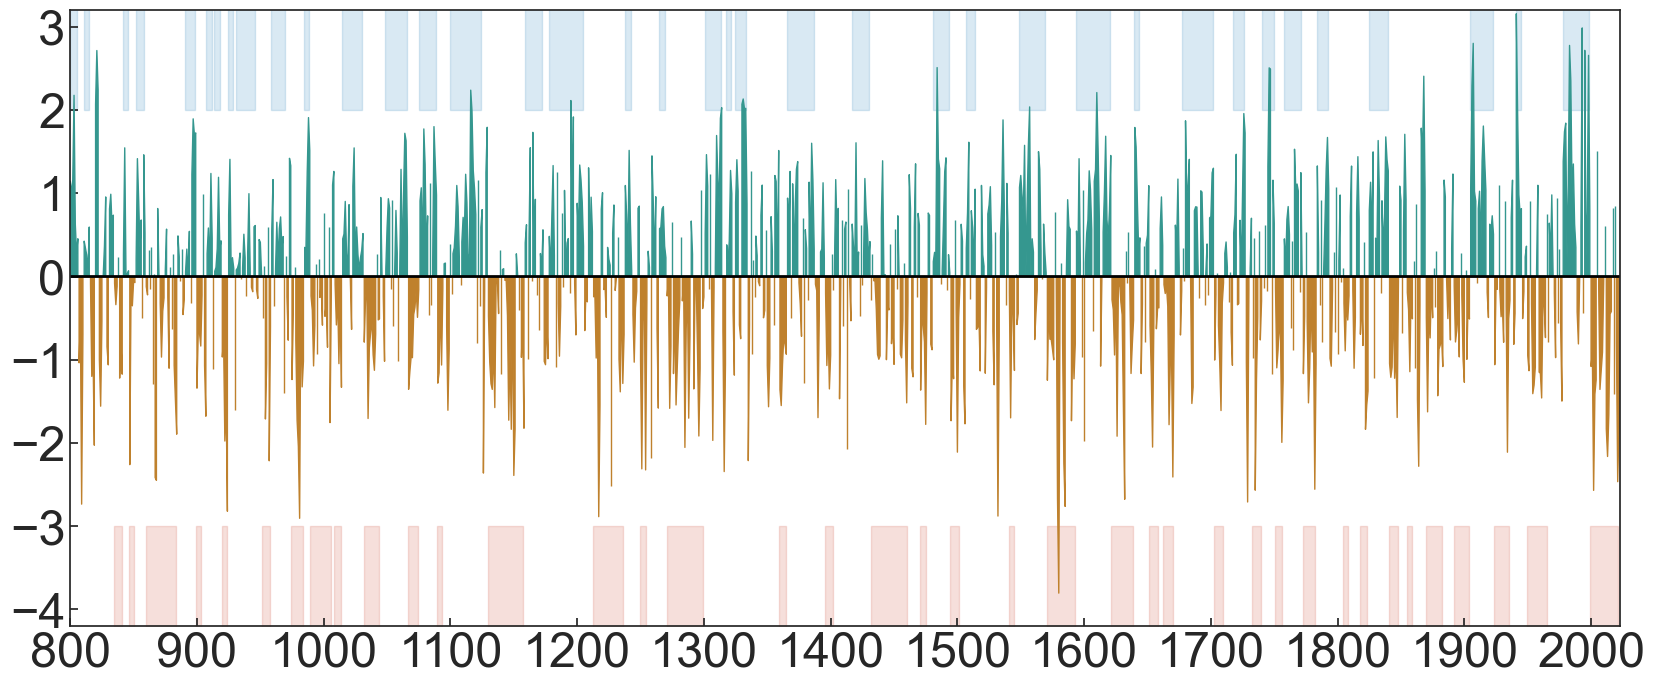

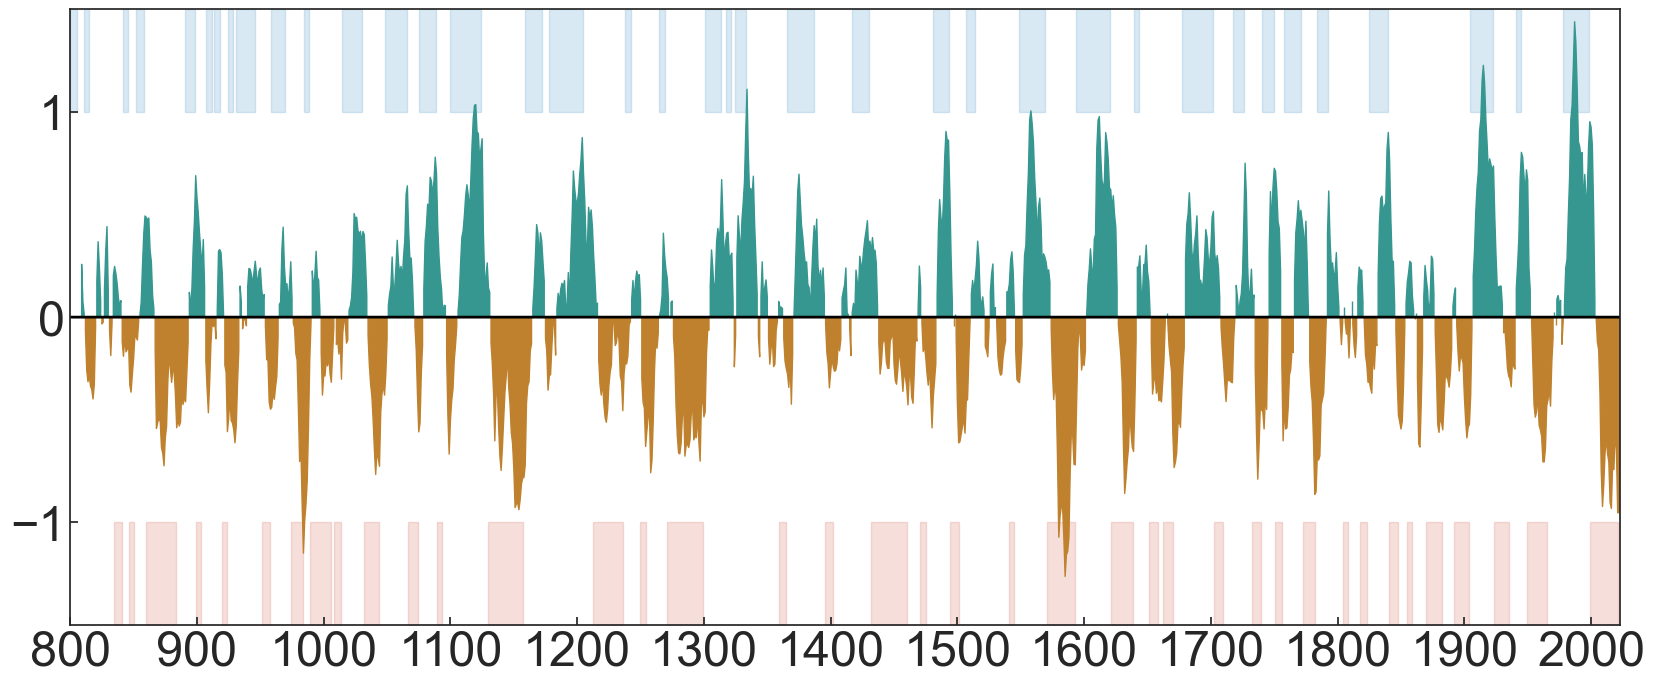

In [3]:
# Load into dataframe
pd_SMseries = pd.read_csv('../data/smrec/recon_2023.txt',delimiter=',')

# Pull out bias-corrected reconustruction and observational time series
sm_obs_yr = np.array(pd_SMseries['year'][:])
sm_obs_all = np.array(pd_SMseries['recon'][:])

# For zero line
y_zeros = np.zeros(sm_obs_yr.shape)

# Create Rolling Means of soil moisture
sm_5yr  = np.array(pd.Series(sm_obs_all).rolling(5).mean())
sm_10yr = np.array(pd.Series(sm_obs_all).rolling(10).mean())

# Load data
df_pluvial = pd.read_csv('../data/pluv_sm10yr_update_2024.csv')
df_drought = pd.read_csv('../data/drght_sm10yr_update_2024.csv')

# Pull out duration/odd years/cumsum
dur_pluv    = np.array(df_pluvial['Duration']); dur_drgt    = np.array(df_drought['Duration'])
cumsum_pluv = np.array(df_pluvial['CumSum']);   cumsum_drgt = np.array(df_drought['CumSum'])
outyrs_pluv = np.array(df_pluvial['DryYrs']);   outyrs_drgt = np.array(df_drought['WetYrs'])

# Specific values for 20th century events
i_loc = np.where(df_pluvial.FirstYr==1978)[0]; pluv_late20th  = df_pluvial.iloc[i_loc,:]
i_loc = np.where(df_pluvial.FirstYr==1905)[0]; pluv_early20th = df_pluvial.iloc[i_loc,:]
i_loc = np.where(df_drought.FirstYr==2000)[0]; drgt_early21st = df_drought.iloc[i_loc,:]


# Set minimum drought/pluvial length
min_len = 1

# Pull out list of first and last year of pluvial events-------------------------------------------------------
pluv_yrbeg  = np.array(df_pluvial.FirstYr[df_pluvial['Duration']>=min_len])
pluv_yrend  = np.array(df_pluvial.LastYr[df_pluvial['Duration']>=min_len])
pluv_length = np.array(df_pluvial.Duration[df_pluvial['Duration']>=min_len])
pluv_yrterm = pluv_yrend+1

# Loop through pluvial events
for n_pluv in np.arange(0,pluv_yrbeg.size):  
    # All years, current pluvial
    currpluv_yrs = np.arange(pluv_yrbeg[n_pluv],pluv_yrend[n_pluv]+1)

    # If first event, use this to initialize all years array
    if n_pluv==0:
        allpluv_yrs = currpluv_yrs.copy()
    # Otherwise, append
    else:
        allpluv_yrs = np.hstack((allpluv_yrs,currpluv_yrs))
    
print('# extended pluvial years =',np.size(allpluv_yrs))

# Pull out list of first and last year of drought events-------------------------------------------------------
drgt_yrbeg  = np.array(df_drought.FirstYr[df_drought['Duration']>=min_len])
drgt_yrend  = np.array(df_drought.LastYr[df_drought['Duration']>=min_len])
drgt_length = np.array(df_drought.Duration[df_drought['Duration']>=min_len])
drgt_yrterm = drgt_yrend+1

# Loop through pluvial events
for n_drgt in np.arange(0,drgt_yrbeg.size):  
    # All years, current pluvial
    currdrgt_yrs = np.arange(drgt_yrbeg[n_drgt],drgt_yrend[n_drgt]+1)

    # If first event, use this to initialize all years array
    if n_drgt==0:
        alldrgt_yrs = currdrgt_yrs.copy()
    # Otherwise, append
    else:
        alldrgt_yrs = np.hstack((alldrgt_yrs,currdrgt_yrs))
    
print('# extended drought years =',np.size(alldrgt_yrs))

# Years that don't fall within the extended droughts or pluvials
allother_yrs = np.setxor1d(sm_obs_yr,np.hstack((alldrgt_yrs,allpluv_yrs)))

print('# other years =',np.size(allother_yrs))

print('# SUM =',np.size(allother_yrs)+np.size(alldrgt_yrs)+np.size(allpluv_yrs))
print('# TOTAL YEARS =',sm_obs_yr.size)

# Figure: unsmoothed
plt.figure(figsize=(20,8),facecolor="white")
sns.set_style("ticks",style_new)
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1.5})
plt.plot(sm_obs_yr,y_zeros,'-', color='k', linewidth=2)
# Shading
i_neg=sm_obs_all.copy(); i_neg[np.where(i_neg>=0)]=0; i_neg[np.where(i_neg<0)]=1
i_pos=sm_obs_all.copy(); i_pos[np.where(i_neg==0)]=1; i_pos[np.where(i_neg==1)]=0
plt.fill_between(sm_obs_yr, y_zeros, sm_obs_all, where=i_neg, color='#bf812d', alpha=1)
plt.fill_between(sm_obs_yr, y_zeros, sm_obs_all, where=i_pos, color='#35978f', alpha=1)
plt.yticks([-4,-3,-2,-1,0,1,2,3,4],fontsize=35)
# Highlight Extended Droughts
for n_event in enumerate(drgt_length):
    ymin=-5; ymax=-3
    if n_event[1]>=1:
        plt.fill_between(np.arange(drgt_yrbeg[n_event[0]]-0.5,drgt_yrend[n_event[0]]+0.5), ymin, ymax,color='#d6604d',alpha=0.2,zorder=0)
# Highlight Extended Pluvials
for n_event in enumerate(pluv_length):
    ymin=2; ymax=3.5
    if n_event[1]>=1:
        plt.fill_between(np.arange(pluv_yrbeg[n_event[0]]-0.5,pluv_yrend[n_event[0]]+0.5), ymin, ymax,color='#4393c3',alpha=0.2,zorder=0)
plt.xticks([800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000],fontsize=35)
plt.xlim(800,2023)
plt.ylim(-4.2,3.2)
#plt.savefig('../figures/sm200_recon_1yr_update_pluvs_drghts.pdf',format='pdf')

# Figure: unsmoothed
plt.figure(figsize=(20,8),facecolor="white")
sns.set_style("ticks",style_new)
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1.5})
plt.plot(sm_obs_yr,y_zeros,'-', color='k', linewidth=2)
# Shading
i_neg=sm_10yr.copy(); i_neg[np.where(i_neg>=0)]=0; i_neg[np.where(i_neg<0)]=1
i_pos=sm_10yr.copy(); i_pos[np.where(i_neg==0)]=1; i_pos[np.where(i_neg==1)]=0
plt.fill_between(sm_obs_yr, y_zeros, sm_10yr, where=i_neg, color='#bf812d', alpha=1)
plt.fill_between(sm_obs_yr, y_zeros, sm_10yr, where=i_pos, color='#35978f', alpha=1)
plt.yticks([-4,-3,-2,-1,0,1,2,3,4],fontsize=35)
# Highlight Extended Droughts
for n_event in enumerate(drgt_length):
    ymin=-1.5; ymax=-1
    if n_event[1]>=1:
        plt.fill_between(np.arange(drgt_yrbeg[n_event[0]]-0.5,drgt_yrend[n_event[0]]+0.5), ymin, ymax,color='#d6604d',alpha=0.2,zorder=0)
# Highlight Extended Pluvials
for n_event in enumerate(pluv_length):
    ymin=1; ymax=1.5
    if n_event[1]>=1:
        plt.fill_between(np.arange(pluv_yrbeg[n_event[0]]-0.5,pluv_yrend[n_event[0]]+0.5), ymin, ymax,color='#4393c3',alpha=0.2,zorder=0)
plt.xticks([800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000],fontsize=35)
plt.xlim(800,2023)
plt.ylim(-1.5,1.5)
#plt.savefig('../figures/sm200_recon_10yr_smooth_update_pluvs_drghts.pdf',format='pdf')


# Overlapping Years
overlap_yrs = np.intersect1d(alldrgt_yrs,allpluv_yrs)
print('')
print('Overlapping Years')
print(overlap_yrs)


## Check a Couple Things

In [4]:
# 1905-1923
yr_event = np.arange(1905,1923+1)
i_event  = np.nonzero(np.in1d(sm_obs_yr,yr_event))[0]
sm_event = sm_obs_all[i_event].copy()
yrs_wet_earlyPLUV = yr_event[np.where(sm_event>0)].copy()


## Load All Instrumental Climate Indices

In [15]:
# NINO 3.4 (ENSO)----------------------------------------------------------------------------------------------------------

# Load into dataframes
# https://psl.noaa.gov/gcos_wgsp/Timeseries/Nino34/
df_nino34   = pd.read_csv('../data/obsindices/nino34.txt',delim_whitespace=True, header=None)
yr_nino34   = np.array(df_nino34.iloc[:,0])
data_nino34 = np.array(df_nino34.iloc[:,1:])

# AMO Index, from hadiSST--------------------------------------------------------------------------------------------------
# https://climexp.knmi.nl/getindices.cgi?WMO=UKMOData/amo_hadsst&STATION=AMO_hadsst&TYPE=i&id=someone@somewhere
# # version :: HadSST.4.0.1.0
# Load into dataframes
df_amo   = pd.read_csv('../data/obsindices/amo_hadsst4.csv',delim_whitespace=True, header=None)
yr_amo   = np.array(df_amo.iloc[:,0])
data_amo = np.array(df_amo.iloc[:,1:])

# Pacific Decadal Oscillation Index------------------------------------------------------------------------------------------
# https://www.ncei.noaa.gov/access/monitoring/pdo/
# Load into dataframes
df_pdo   = pd.read_csv('../data/obsindices/pdo_ncei.txt',delim_whitespace=True, header=None)
yr_pdo   = np.array(df_pdo.iloc[:,0])
data_pdo = np.array(df_pdo.iloc[:,1:])

# Replace missing values with NaN
data_nino34[data_nino34<=-90]=np.nan
data_amo[data_amo<=-90]=np.nan
data_pdo[data_pdo>=90]=np.nan

# Seasonal Averages---------------------------------------------------------------------------------------------------------

# Common Period (anchored to January; AO only comes up through 2015)
#yrs_seas = np.arange(1902,2023+1)
yrs_seas = np.arange(1871,2023+1)

# Arrays containing all seasonal information: name, months, indices
all_seas_txt  = np.array(['SON','DJF','MAM','JJA'])
all_seas_mons = np.array([[9,10,11],[12,1,2],[3,4,5],[6,7,8]])
all_seas_inds = np.array([[-1,-1,-1],[-1,0,0],[0,0,0],[0,0,0]])

# Storage Arrays
seas_nino34 = np.zeros((all_seas_txt.size,3,yrs_seas.size))*np.nan
seas_amo    = np.zeros((all_seas_txt.size,3,yrs_seas.size))*np.nan
seas_pdo    = np.zeros((all_seas_txt.size,3,yrs_seas.size))*np.nan

# Seasonal loop
for n_seas in enumerate(all_seas_txt):
    # Current seasonal information
    seas_txt  = copy.deepcopy(n_seas[1])
    seas_mons = all_seas_mons[n_seas[0]].copy()
    ind_yr     = all_seas_inds[n_seas[0]].copy()
    
    print('------------------')
    print(seas_txt)
    print(seas_mons)
    print(ind_yr)
    print('------------------')
    
    # Loop through each year and month
    for n_yr in enumerate(yrs_seas):
        for n_mon in enumerate(seas_mons):
            # Current stuff
            curr_yr  = n_yr[1]+ind_yr[n_mon[0]]
            curr_mon = n_mon[1]
            print('      ',curr_yr,curr_mon)

            # Month loc index
            i_mon = np.where(mons==curr_mon)[0]
        
            # Find year location, accounting for lag across calendar years
            i_yr_nino34 = np.where( (yr_nino34==curr_yr) )[0]
            i_yr_amo    = np.where( (yr_amo==curr_yr) )[0]
            i_yr_pdo    = np.where( (yr_pdo==curr_yr) )[0]

            # Store current values
            # use sum here to convert 0 dimensional array into scalar
            seas_nino34[n_seas[0],n_mon[0],n_yr[0]]   = np.sum(data_nino34[i_yr_nino34,i_mon]).copy()
            seas_amo[n_seas[0],n_mon[0],n_yr[0]]      = np.sum(data_amo[i_yr_amo,i_mon]).copy()
            seas_pdo[n_seas[0],n_mon[0],n_yr[0]]      = np.sum(data_pdo[i_yr_pdo,i_mon]).copy()

# Create seasonal averages/sums
seas_ave_nino34 = np.mean(seas_nino34,axis=1)
seas_ave_amo    = np.mean(seas_amo,axis=1)
seas_ave_pdo    = np.mean(seas_pdo,axis=1)

# Recenter Everything to zero mean
mean_nino34 = np.nanmean(seas_ave_nino34,axis=1); seas_ave_nino34 = seas_ave_nino34-np.expand_dims(mean_nino34,axis=1)
mean_amo    = np.nanmean(seas_ave_amo,axis=1);    seas_ave_amo    = seas_ave_amo-np.expand_dims(mean_amo,axis=1)
mean_pdo    = np.nanmean(seas_ave_pdo,axis=1);    seas_ave_pdo    = seas_ave_pdo-np.expand_dims(mean_pdo,axis=1)


------------------
SON
[ 9 10 11]
[-1 -1 -1]
------------------
       1870 9
       1870 10
       1870 11
       1871 9
       1871 10
       1871 11
       1872 9
       1872 10
       1872 11
       1873 9
       1873 10
       1873 11
       1874 9
       1874 10
       1874 11
       1875 9
       1875 10
       1875 11
       1876 9
       1876 10
       1876 11
       1877 9
       1877 10
       1877 11
       1878 9
       1878 10
       1878 11
       1879 9
       1879 10
       1879 11
       1880 9
       1880 10
       1880 11
       1881 9
       1881 10
       1881 11
       1882 9
       1882 10
       1882 11
       1883 9
       1883 10
       1883 11
       1884 9
       1884 10
       1884 11
       1885 9
       1885 10
       1885 11
       1886 9
       1886 10
       1886 11
       1887 9
       1887 10
       1887 11
       1888 9
       1888 10
       1888 11
       1889 9
       1889 10
       1889 11
       1890 9
       1890 10
       1890 11
       1891 

/var/folders/tn/n6r82fln4w96xwgsmyktfwjh0000gn/T/ipykernel_80405/1904932815.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_nino34   = pd.read_csv('../data/obsindices/nino34.txt',delim_whitespace=True, header=None)
/var/folders/tn/n6r82fln4w96xwgsmyktfwjh0000gn/T/ipykernel_80405/1904932815.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_amo   = pd.read_csv('../data/obsindices/amo_hadsst4.csv',delim_whitespace=True, header=None)
/var/folders/tn/n6r82fln4w96xwgsmyktfwjh0000gn/T/ipykernel_80405/1904932815.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_pdo   = pd.read_csv('../data/obsindices/pdo_ncei.txt',delim_whitespace=True, header=None)


## Load Precipitation Data

In [16]:
# Year Vector for Precipitation
yr_prec       = np.arange(1901,2023+1)
yrs_seas_prec = np.arange(1902,2023+1)

# File Name
fname_in   = '../data/prec.nc'
prec_nc    = netCDF4.Dataset(fname_in,"r",format="NETCDF4")
prec       = prec_nc.variables['prec'][:] # get values
lat        = prec_nc.variables['lat'][:] # get values
lon        = prec_nc.variables['lon'][:] # get values
prec_nc.close()

# Reshape
prec_all = np.reshape(prec,(yr_prec.size,mons.size,lat.size,lon.size))

# Storage Arrays
seas_prec   = np.zeros((all_seas_txt.size,3,yrs_seas_prec.size,lat.size,lon.size))*np.nan

# Seasonal loop
for n_seas in enumerate(all_seas_txt):
    # Current seasonal information
    seas_txt  = copy.deepcopy(n_seas[1])
    seas_mons = all_seas_mons[n_seas[0]].copy()
    ind_yr     = all_seas_inds[n_seas[0]].copy()
    
    print('------------------')
    print(seas_txt)
    print(seas_mons)
    print(ind_yr)
    print('------------------')
    
    # Loop through each year and month
    for n_yr in enumerate(yrs_seas_prec):
        for n_mon in enumerate(seas_mons):
            # Current stuff
            curr_yr  = n_yr[1]+ind_yr[n_mon[0]]
            curr_mon = n_mon[1]
            print('      ',curr_yr,curr_mon)

            # Month loc index
            i_mon = np.where(mons==curr_mon)[0]
        
            # Find year location, accounting for lag across calendar years
            i_yr_prec   = np.where( (yr_prec==curr_yr) )[0]

            # Store current values
            seas_prec[n_seas[0],n_mon[0],n_yr[0],:,:] = prec_all[i_yr_prec,i_mon,:,:].copy()

# Create seasonal averages/sums
seas_ave_prec   = np.sum(seas_prec,axis=1)


------------------
SON
[ 9 10 11]
[-1 -1 -1]
------------------
       1901 9
       1901 10
       1901 11
       1902 9
       1902 10
       1902 11
       1903 9
       1903 10
       1903 11
       1904 9
       1904 10
       1904 11
       1905 9
       1905 10
       1905 11
       1906 9
       1906 10
       1906 11
       1907 9
       1907 10
       1907 11
       1908 9
       1908 10
       1908 11
       1909 9
       1909 10
       1909 11
       1910 9
       1910 10
       1910 11
       1911 9
       1911 10
       1911 11
       1912 9
       1912 10
       1912 11
       1913 9
       1913 10
       1913 11
       1914 9
       1914 10
       1914 11
       1915 9
       1915 10
       1915 11
       1916 9
       1916 10
       1916 11
       1917 9
       1917 10
       1917 11
       1918 9
       1918 10
       1918 11
       1919 9
       1919 10
       1919 11
       1920 9
       1920 10
       1920 11
       1921 9
       1921 10
       1921 11
       1922 

## Load 20th Century Reanalysis Files (Specific Height)
* geopotential heights, v-wind
* set up some parameters for the analysis

In [18]:
# Choose Height
hgt_lev = 200

# Link To File
fname_20C_hgt = '../../../../GEODATA/20thCRv3/hgt.mon.mean.nc'
fname_20C_vwd = '../../../../GEODATA/20thCRv3/vwnd.mon.mean.nc'

# Open Netcdf Data Structure
ncfile_20C_hgt = netCDF4.Dataset(fname_20C_hgt)             
ncfile_20C_vwd = netCDF4.Dataset(fname_20C_vwd)             

# Pull out all dimension data
lat_20C    = ncfile_20C_hgt.variables['lat'][:]  # latitude, degrees
lon_20C    = ncfile_20C_hgt.variables['lon'][:]  # longitude, degrees
level      = ncfile_20C_hgt.variables['level'][:]  # longitude, degrees

# Time information
nctime    = ncfile_20C_hgt.variables['time'][:]     # time data
unit_time = ncfile_20C_hgt.variables['time'].units  # units
cal_time  = 'standard'                              # calendar not specified in file, so use this

# Index for level desired
i_lev = np.where(level==hgt_lev)[0]

# Load geopotential and v winds at the specified height
hgt_mon = np.squeeze(ncfile_20C_hgt.variables['hgt'][:,i_lev,:,:])  
vwd_mon = np.squeeze(ncfile_20C_vwd.variables['vwnd'][:,i_lev,:,:]) 

# For Recentering on Greenwhich
lon_new = lon_20C-180
i_west  = np.where(lon_20C>=180)[0]
i_east  = np.where(lon_20C<180)[0]

# Close files
ncfile_20C_hgt.close()
ncfile_20C_vwd.close()

#-----------------------------------------------------------------------------------------------------------------------------------------------------

# Loop through and pull out year and month vectors from datetime object. 
# I will use these for indexing the 20th Century Reanalysis Data
yr_vect  = np.zeros(np.shape(nctime))
mon_vect = np.zeros(np.shape(nctime))

# Create Year and Month Vectors
for i_date in enumerate(nctime):
    yr_vect[i_date[0]]  = netCDF4.num2date(nctime[i_date[0]],units=unit_time,calendar=cal_time).year
    mon_vect[i_date[0]] = netCDF4.num2date(nctime[i_date[0]],units=unit_time,calendar=cal_time).month

# Unique year vector
yrs_20C = np.unique(yr_vect)


## (5) Seasonal averages, 20th CR

In [19]:
# Unique Year Vector
yr_seas_20CR = np.arange(1837,2015+1)

# Storage Arrays
seas_hgt   = np.zeros((all_seas_txt.size,3,yr_seas_20CR.size,lat_20C.size,lon_20C.size))*np.nan

# Seasonal loop
for n_seas in enumerate(all_seas_txt):
    # Current seasonal information
    seas_txt  = copy.deepcopy(n_seas[1])
    seas_mons = all_seas_mons[n_seas[0]].copy()
    ind_yr     = all_seas_inds[n_seas[0]].copy()
    
    print('------------------')
    print(seas_txt)
    print(seas_mons)
    print(ind_yr)
    print('------------------')
    
    # Loop through each year and month
    for n_yr in enumerate(yr_seas_20CR):
        for n_mon in enumerate(seas_mons):
            # Current stuff
            curr_yr  = n_yr[1]+ind_yr[n_mon[0]]
            curr_mon = n_mon[1]
            i_loc_20CR = np.where( (yr_vect==curr_yr) & (mon_vect==curr_mon) )[0]
            print('      ',yr_vect[i_loc_20CR],mon_vect[i_loc_20CR])           
            
            # Store current values
            seas_hgt[n_seas[0],n_mon[0],n_yr[0],:,:] = hgt_mon[i_loc_20CR,:,:].copy()

# Create seasonal averages/sums
seas_hgt   = np.mean(seas_hgt,axis=1)


------------------
SON
[ 9 10 11]
[-1 -1 -1]
------------------
       [1836.] [9.]
       [1836.] [10.]
       [1836.] [11.]
       [1837.] [9.]
       [1837.] [10.]
       [1837.] [11.]
       [1838.] [9.]
       [1838.] [10.]
       [1838.] [11.]
       [1839.] [9.]
       [1839.] [10.]
       [1839.] [11.]
       [1840.] [9.]
       [1840.] [10.]
       [1840.] [11.]
       [1841.] [9.]
       [1841.] [10.]
       [1841.] [11.]
       [1842.] [9.]
       [1842.] [10.]
       [1842.] [11.]
       [1843.] [9.]
       [1843.] [10.]
       [1843.] [11.]
       [1844.] [9.]
       [1844.] [10.]
       [1844.] [11.]
       [1845.] [9.]
       [1845.] [10.]
       [1845.] [11.]
       [1846.] [9.]
       [1846.] [10.]
       [1846.] [11.]
       [1847.] [9.]
       [1847.] [10.]
       [1847.] [11.]
       [1848.] [9.]
       [1848.] [10.]
       [1848.] [11.]
       [1849.] [9.]
       [1849.] [10.]
       [1849.] [11.]
       [1850.] [9.]
       [1850.] [10.]
       [1850.] [11.]
      

## Trim and detrend height anomalies (units of meters)

In [20]:
# Lowess window: using 50-year filter to remove long term trends but retain multidecadal variability---------------------------------------------------------------
yrs_smooth = 50;

# Fractional smooth
frac_smooth = yrs_smooth/yr_seas_20CR.size

# Storage Array
seas_hgt_anom = np.zeros(seas_hgt.shape)*np.nan

# Loops for lowess detrended
# lat/lon loops
for n_lat in enumerate(lat_20C):
    for n_lon in enumerate(lon_20C):
        # Seasonal loop
        for n_seas in enumerate(all_seas_txt):
            
            # Current Cell
            currcell = seas_hgt[n_seas[0],:,n_lat[0],n_lon[0]].copy()

            # Apply Smoothing
            currcell_smooth = statsmodels.nonparametric.smoothers_lowess.lowess(currcell,yr_seas_20CR,frac=frac_smooth)   # 30 year lowess

            # Remove lowess signal to convert to anomaly
            currcell_anom = currcell-currcell_smooth[:,1]

            # Store Data
            seas_hgt_anom[n_seas[0],:,n_lat[0],n_lon[0]] = currcell_anom.copy()

# Trim to 1902-2015
i_trim = np.where(yr_seas_20CR>=1902)[0]
yrs_20C_trim = yr_seas_20CR[i_trim].copy()
seas_hgt_anom_trim = seas_hgt_anom[:,i_trim,:,:].copy()

# testing stuff
#  #  test_series = seas_hgt[1,:,90,180].copy()
#  #  
#  #  # Calculate the lowess smooth
#  test_smooth = statsmodels.nonparametric.smoothers_lowess.lowess(currcell,yr_seas_20CR,frac=frac_smooth)   # 30 year lowess
#      
#  # Remove lowess signal
#  test_anom_lowess = currcell-test_smooth[:,1]
#  
#  plt.figure()
#  plt.plot(yr_seas_20CR,currcell)
#  plt.plot(yr_seas_20CR,test_smooth[:,1],color='r')
#  plt.xlim(1870,2015)
#  
#  plt.figure()
#  plt.plot(yr_seas_20CR,currcell_anom)
#  plt.xlim(1870,2020)
#  

## Choose Season To Analyze and Select Data: PRECIPITATION & HGT

In [26]:
# Select Season
#curr_seas = 'SON'; 
curr_seas = 'DJF'; 
#curr_seas = 'MAM'; 
#curr_seas = 'JJA'; 

# Index for current season
i_seas = np.where(all_seas_txt==curr_seas)[0]

# Thresholds for climate modes------------------------------------------------------------------------------------------------------------------------------

# ENSO
thresh_negNINO = np.nanpercentile(seas_ave_nino34[i_seas,:],33)
thresh_posNINO = np.nanpercentile(seas_ave_nino34[i_seas,:],66)

# PDO
thresh_negPDO = np.nanpercentile(seas_ave_pdo[i_seas,:],33)
thresh_posPDO = np.nanpercentile(seas_ave_pdo[i_seas,:],66)

# AMO
thresh_negAMO = np.nanpercentile(seas_ave_amo[i_seas,:],33)
thresh_posAMO = np.nanpercentile(seas_ave_amo[i_seas,:],66)

# PRECIPITATION----------------------------------------------------------------------------------------------------------------------------------------------

# Overlap years between climate indices and precipitation data
i_over = np.nonzero(np.in1d(yrs_seas,yrs_seas_prec))[0]

# Pull out current seasonal data
currseas_prec = np.squeeze(seas_ave_prec[i_seas,:,:,:].copy())
currseas_nino = seas_ave_nino34[i_seas,i_over].copy()
currseas_pdo  = seas_ave_pdo[i_seas,i_over].copy()
currseas_amo  = seas_ave_amo[i_seas,i_over].copy()

# Calculate precipitation climatology
prec_clim  = np.nanmean(currseas_prec,axis=0);     

# Indices for megapluvials/megadrought
i_early20 = np.where( (yrs_seas_prec>=1905) & (yrs_seas_prec<=1923) )[0]
i_late20  = np.where( (yrs_seas_prec>=1978) & (yrs_seas_prec<=1999) )[0]
i_mega21  = np.where( (yrs_seas_prec>=2000) & (yrs_seas_prec<=2022) )[0]

# Indices for climate modes
i_negNINO = np.where(currseas_nino<=thresh_negNINO)[0]; i_posNINO = np.where(currseas_nino>=thresh_posNINO)[0]
i_negPDO  = np.where(currseas_pdo<=thresh_negPDO)[0];   i_posPDO  = np.where(currseas_pdo>=thresh_posPDO)[0]
i_negAMO  = np.where(currseas_amo<=thresh_negAMO)[0];   i_posAMO  = np.where(currseas_amo>=thresh_posAMO)[0]

# Composites Events
# pluvials/drought
prec_anom_EARLY = ((np.mean(currseas_prec[i_early20,:,:],axis=0)-prec_clim)/prec_clim)*100
prec_anom_LATE = ((np.mean(currseas_prec[i_late20,:,:],axis=0)-prec_clim)/prec_clim)*100
prec_anom_MEGA = ((np.mean(currseas_prec[i_mega21,:,:],axis=0)-prec_clim)/prec_clim)*100
# ENSO
prec_anom_ELNINO = ((np.mean(currseas_prec[i_posNINO,:,:],axis=0)-prec_clim)/prec_clim)*100
prec_anom_LANINA = ((np.mean(currseas_prec[i_negNINO,:,:],axis=0)-prec_clim)/prec_clim)*100
# PDO
prec_anom_posPDO = ((np.mean(currseas_prec[i_posPDO,:,:],axis=0)-prec_clim)/prec_clim)*100
prec_anom_negPDO = ((np.mean(currseas_prec[i_negPDO,:,:],axis=0)-prec_clim)/prec_clim)*100
# AMO
prec_anom_posAMO = ((np.mean(currseas_prec[i_posAMO,:,:],axis=0)-prec_clim)/prec_clim)*100
prec_anom_negAMO = ((np.mean(currseas_prec[i_negAMO,:,:],axis=0)-prec_clim)/prec_clim)*100

# HEIGHTS----------------------------------------------------------------------------------------------------------------------------------------------

# Overlap years between climate indices and precipitation data
i_over = np.nonzero(np.in1d(yrs_seas,yrs_20C_trim))[0]

# Pull out current seasonal data
currseas_hgt = np.squeeze(seas_hgt_anom_trim[i_seas,:,:,:].copy())
#currseas_hgt = (currseas_hgt-np.mean(currseas_hgt,axis=0))/np.std(currseas_hgt,axis=0)
currseas_nino = seas_ave_nino34[i_seas,i_over].copy()
currseas_pdo  = seas_ave_pdo[i_seas,i_over].copy()
currseas_amo  = seas_ave_amo[i_seas,i_over].copy()

# Indices for megapluvials/megadrought
i_early20 = np.where( (yrs_20C_trim>=1905) & (yrs_20C_trim<=1923) )[0]
i_late20  = np.where( (yrs_20C_trim>=1978) & (yrs_20C_trim<=1999) )[0]
i_mega21  = np.where( (yrs_20C_trim>=2000) & (yrs_20C_trim<=2022) )[0]

# Indices for climate modes
i_negNINO = np.where(currseas_nino<=thresh_negNINO)[0]; i_posNINO = np.where(currseas_nino>=thresh_posNINO)[0]
i_negPDO  = np.where(currseas_pdo<=thresh_negPDO)[0];   i_posPDO  = np.where(currseas_pdo>=thresh_posPDO)[0]
i_negAMO  = np.where(currseas_amo<=thresh_negAMO)[0];   i_posAMO  = np.where(currseas_amo>=thresh_posAMO)[0]

# Composites Events
# pluvials/drought
hgt_anom_EARLY = np.mean(currseas_hgt[i_early20,:,:],axis=0)
hgt_anom_LATE  = np.mean(currseas_hgt[i_late20,:,:],axis=0)
hgt_anom_MEGA  = np.mean(currseas_hgt[i_mega21,:,:],axis=0)
# ENSO
hgt_anom_ELNINO = np.mean(currseas_hgt[i_posNINO,:,:],axis=0)
hgt_anom_LANINA = np.mean(currseas_hgt[i_negNINO,:,:],axis=0)
# PDO
hgt_anom_posPDO = np.mean(currseas_hgt[i_posPDO,:,:],axis=0)
hgt_anom_negPDO = np.mean(currseas_hgt[i_negPDO,:,:],axis=0)
# AMO
hgt_anom_posAMO = np.mean(currseas_hgt[i_posAMO,:,:],axis=0)
hgt_anom_negAMO = np.mean(currseas_hgt[i_negAMO,:,:],axis=0)


## Create Map of Composite Anomalies

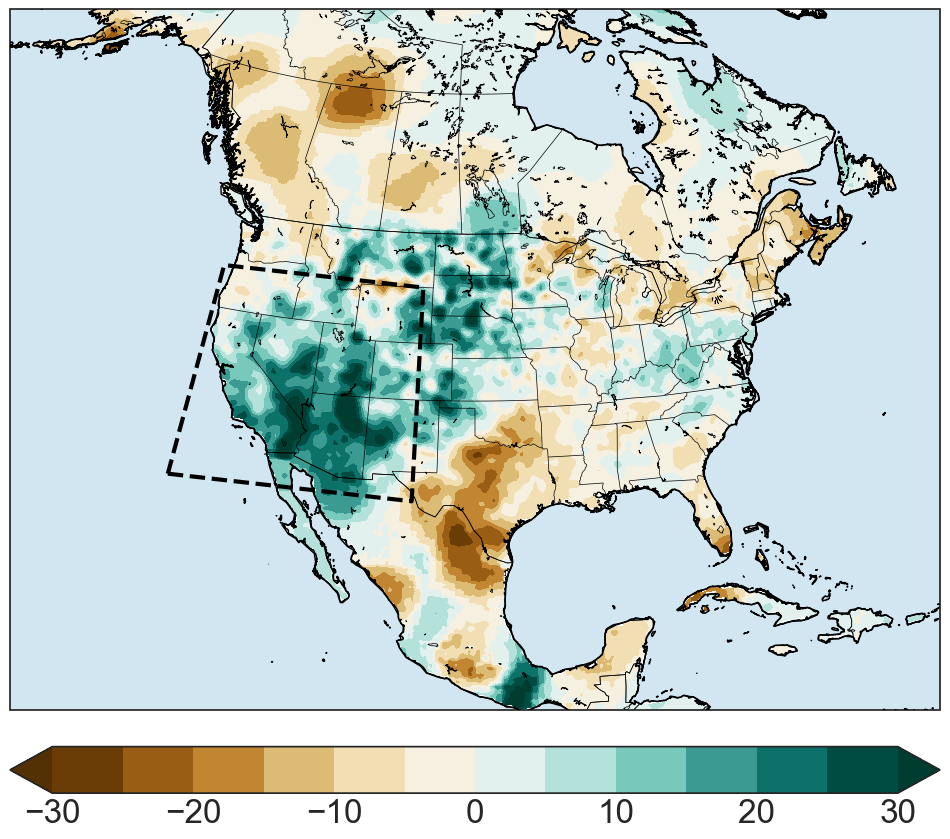

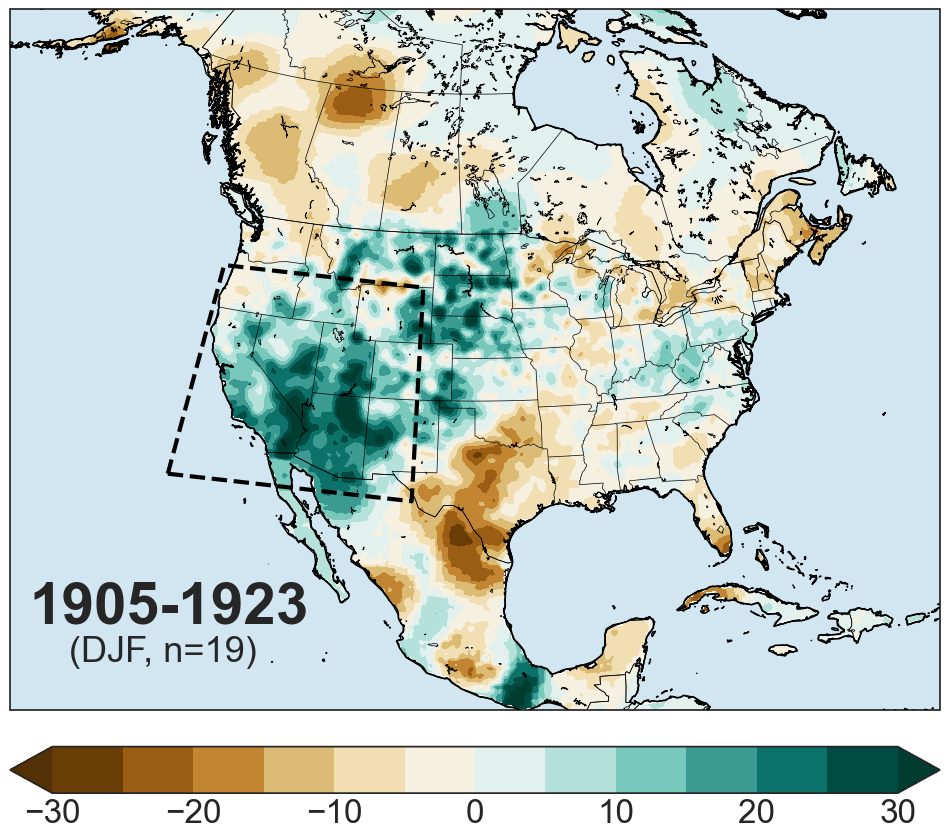

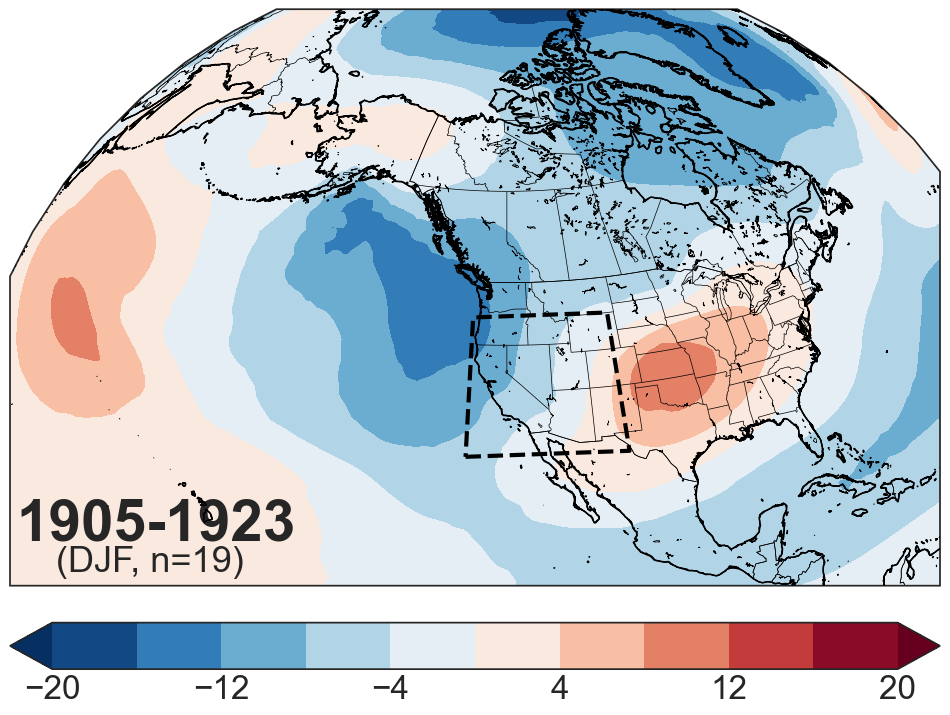

In [27]:
# shapely kicks up a bunch of warnings
import warnings
warnings.filterwarnings("ignore")

# Choose Event
event_txt='1905-1923'; num_events=i_early20.size;  map_event = copy.deepcopy(prec_anom_EARLY);   map_event_hgt = copy.deepcopy(hgt_anom_EARLY);
#event_txt='1978-1999'; num_events=i_late20.size;   map_event = copy.deepcopy(prec_anom_LATE);    map_event_hgt = copy.deepcopy(hgt_anom_LATE);
#event_txt='2000-2022'; num_events=i_mega21.size;   map_event = copy.deepcopy(prec_anom_MEGA);    map_event_hgt = copy.deepcopy(hgt_anom_MEGA);

#event_txt='El Niño';   num_events=i_posNINO.size;  map_event = copy.deepcopy(prec_anom_ELNINO);  map_event_hgt = copy.deepcopy(hgt_anom_ELNINO); 
#event_txt='+PDO';      num_events=i_posPDO.size;   map_event = copy.deepcopy(prec_anom_posPDO);  map_event_hgt = copy.deepcopy(hgt_anom_posPDO);
#event_txt='-AMO';      num_events=i_negAMO.size;   map_event = copy.deepcopy(prec_anom_negAMO);  map_event_hgt = copy.deepcopy(hgt_anom_negAMO); 

#event_txt='La Niña';   num_events=i_negNINO.size;  map_event = copy.deepcopy(prec_anom_LANINA);  map_event_hgt = copy.deepcopy(hgt_anom_LANINA); 
#event_txt='-PDO';      num_events=i_negPDO.size;   map_event = copy.deepcopy(prec_anom_negPDO);  map_event_hgt = copy.deepcopy(hgt_anom_negPDO);
#event_txt='+AMO';      num_events=i_posAMO.size;   map_event = copy.deepcopy(prec_anom_posAMO);  map_event_hgt = copy.deepcopy(hgt_anom_posAMO); 

# ALT PRECIPITATION FIGURE (NO INSET TEXT)--------------------------------------------------------------------------------------------------------------------
# Set up for map
curr_latlon = np.array([-125,-105,30,45])
clevs = np.array([-150,-125,-100,-75,-50,-25,0,25,50,75,100,125,150])/5;
nmap  = plt.cm.get_cmap(name=plt.cm.BrBG,lut=clevs.size-1)
extent_lonlat = (-135, -65, 15, 65)
clevs_units   = clevs.copy()
ocean_color   = np.float64([209,230,241])/255

fig = plt.figure(figsize=(12, 12),facecolor="white")
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-100, central_latitude=25, globe=None))
m = ax.contourf(lon, lat, map_event,clevs,transform=ccrs.PlateCarree(),cmap=nmap,extend="both")
#m = ax.pcolormesh(lon-0.75, lat-0.75, mme_sm, transform=ccrs.PlateCarree(), \
#              cmap=nmap, vmin=np.min(clevs),vmax=np.max(clevs))
ax.coastlines()
ax.set_global()
ax.set_extent(extent_lonlat, crs=ccrs.PlateCarree())
#ax.gridlines(xlocs=np.arange(-180,190,10),ylocs=np.arange(-180,190,10))
plot_rectangle(ax,curr_latlon[0],curr_latlon[1],curr_latlon[2],curr_latlon[3])

ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='-', edgecolor='k')
ax.add_feature(states_provinces, linewidth=0.5, linestyle='-', edgecolor='k')
ax.add_feature(newcoast, linewidth=0.5, linestyle='-', edgecolor='k')
ax.add_feature(newlake, linewidth=0.5, linestyle='-', edgecolor='k')
ax.add_feature(cartopy.feature.LAND,color='w',zorder=0,edgecolor='k')
ax.add_feature(cartopy.feature.OCEAN,color=ocean_color,zorder=0,edgecolor='k')
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='-', edgecolor='k')
#ax.add_feature(cartopy.feature.OCEAN,color=ocean_color,zorder=3)
ax.add_feature(newcoast, linewidth=1, linestyle='-', zorder=4,edgecolor='k')
## Significance Masking
#plot_point(ax,lonmask,latmask)
#ax.text(-122,21,var_txt+' ('+seas_txt+')',transform=ccrs.PlateCarree(),fontsize=32,fontweight="bold", \
#        horizontalalignment='center', verticalalignment='center',)
#ax.text(-123,21,curr_seas,transform=ccrs.PlateCarree(),fontsize=42,fontweight="bold", \
#        horizontalalignment='center', verticalalignment='center',)
#ax.text(-123,18,'('+curr_seas+', n='+str(num_events)+')',transform=ccrs.PlateCarree(),fontsize=26,fontweight="normal", \
#        horizontalalignment='center', verticalalignment='center',)
#for n_reg in enumerate(region_names):
#plot_rectangle(ax,-105,-95,30,47)
# Colorbar
cbar=plt.colorbar(m,orientation="horizontal",fraction=0.08,pad=0.04,ticks=clevs_units[np.arange(0,clevs_units.size+1,2)])
#cbar=plt.colorbar(m,orientation="horizontal")
cbar.ax.tick_params(labelsize=24)
plt.show()
out_name='prec_anom_%_'+curr_seas+'_'+event_txt+'_ALT.eps'
#fig.savefig('../figures/'+out_name,format='eps')

# PRECIPITATION FIGURE--------------------------------------------------------------------------------------------------------------------
# Set up for map
curr_latlon = np.array([-125,-105,30,45])
clevs = np.array([-150,-125,-100,-75,-50,-25,0,25,50,75,100,125,150])/5;
nmap  = plt.cm.get_cmap(name=plt.cm.BrBG,lut=clevs.size-1)
extent_lonlat = (-135, -65, 15, 65)
clevs_units   = clevs.copy()
ocean_color   = np.float64([209,230,241])/255

fig = plt.figure(figsize=(12, 12),facecolor="white")
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-100, central_latitude=25, globe=None))
m = ax.contourf(lon, lat, map_event,clevs,transform=ccrs.PlateCarree(),cmap=nmap,extend="both")
#m = ax.pcolormesh(lon-0.75, lat-0.75, mme_sm, transform=ccrs.PlateCarree(), \
#              cmap=nmap, vmin=np.min(clevs),vmax=np.max(clevs))
ax.coastlines()
ax.set_global()
ax.set_extent(extent_lonlat, crs=ccrs.PlateCarree())
#ax.gridlines(xlocs=np.arange(-180,190,10),ylocs=np.arange(-180,190,10))
plot_rectangle(ax,curr_latlon[0],curr_latlon[1],curr_latlon[2],curr_latlon[3])

ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='-', edgecolor='k')
ax.add_feature(states_provinces, linewidth=0.5, linestyle='-', edgecolor='k')
ax.add_feature(newcoast, linewidth=0.5, linestyle='-', edgecolor='k')
ax.add_feature(newlake, linewidth=0.5, linestyle='-', edgecolor='k')
ax.add_feature(cartopy.feature.LAND,color='w',zorder=0,edgecolor='k')
ax.add_feature(cartopy.feature.OCEAN,color=ocean_color,zorder=0,edgecolor='k')
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='-', edgecolor='k')
#ax.add_feature(cartopy.feature.OCEAN,color=ocean_color,zorder=3)
ax.add_feature(newcoast, linewidth=1, linestyle='-', zorder=4,edgecolor='k')
## Significance Masking
#plot_point(ax,lonmask,latmask)
#ax.text(-122,21,var_txt+' ('+seas_txt+')',transform=ccrs.PlateCarree(),fontsize=32,fontweight="bold", \
#        horizontalalignment='center', verticalalignment='center',)
ax.text(-123,21,event_txt,transform=ccrs.PlateCarree(),fontsize=42,fontweight="bold", \
        horizontalalignment='center', verticalalignment='center',)
ax.text(-123,18,'('+curr_seas+', n='+str(num_events)+')',transform=ccrs.PlateCarree(),fontsize=26,fontweight="normal", \
        horizontalalignment='center', verticalalignment='center',)
#for n_reg in enumerate(region_names):
#plot_rectangle(ax,-105,-95,30,47)
# Colorbar
cbar=plt.colorbar(m,orientation="horizontal",fraction=0.08,pad=0.04,ticks=clevs_units[np.arange(0,clevs_units.size+1,2)])
#cbar=plt.colorbar(m,orientation="horizontal")
cbar.ax.tick_params(labelsize=24)
plt.show()
out_name='prec_anom_%_'+curr_seas+'_'+event_txt+'.eps'
#fig.savefig('../figures/'+out_name,format='eps')

# HEIGHT ANOMALY FIGURE--------------------------------------------------------------------------------------------------------------------
# Set up for map
curr_latlon   = np.array([-125,-105,30,45])
clevs         = np.array([-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30]);   
clevs         = np.array([-20,-16,-12,-8,-4,0,4,8,12,16,20]);   
#clevs         = np.array([-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6])/6;   
#clevs         = np.array([-1,-0.8,-.6,-.4,-.2,0,0.2,0.4,0.6,0.8,1]);   
#clevs         = np.array([-60,-55,-50,-45,-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,45,50,55,60]);   
#clevs         = np.array([-15,-12,-9,-6,-3,0,3,6,9,12,15]);   
#clevs         = np.array([-20,-16,-12,-8,-4,0,4,8,12,16,20]);   
nmap          = plt.cm.get_cmap(name=plt.cm.RdBu_r,lut=clevs.size-1)
extent_lonlat = (-190, -65, 15, 90)
clevs_units   = clevs.copy()
ocean_color   = np.float64([209,230,241])/255

fig = plt.figure(figsize=(12, 12),facecolor="white")
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-120, central_latitude=25, globe=None))
m = ax.contourf(lon_20C, lat_20C, map_event_hgt,clevs,transform=ccrs.PlateCarree(),cmap=nmap,extend="both")
#m = ax.pcolormesh(lon-0.75, lat-0.75, mme_sm, transform=ccrs.PlateCarree(), \
#              cmap=nmap, vmin=np.min(clevs),vmax=np.max(clevs))
ax.coastlines()
ax.set_global()
ax.set_extent(extent_lonlat, crs=ccrs.PlateCarree())
#ax.gridlines(xlocs=np.arange(-180,190,10),ylocs=np.arange(-180,190,10))
plot_rectangle(ax,curr_latlon[0],curr_latlon[1],curr_latlon[2],curr_latlon[3])

ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='-', edgecolor='k')
ax.add_feature(states_provinces, linewidth=0.5, linestyle='-', edgecolor='k')
ax.add_feature(newcoast, linewidth=0.5, linestyle='-', edgecolor='k')
ax.add_feature(newlake, linewidth=0.5, linestyle='-', edgecolor='k')
ax.add_feature(cartopy.feature.LAND,color='w',zorder=0,edgecolor='k')
#ax.add_feature(cartopy.feature.OCEAN,color=ocean_color,zorder=0,edgecolor='k')
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='-', edgecolor='k')
#ax.add_feature(cartopy.feature.OCEAN,color=ocean_color,zorder=3)
ax.add_feature(newcoast, linewidth=1, linestyle='-', zorder=4,edgecolor='k')
## Significance Masking
#plot_point(ax,lonmask,latmask)
#ax.text(-122,21,var_txt+' ('+seas_txt+')',transform=ccrs.PlateCarree(),fontsize=32,fontweight="bold", \
#        horizontalalignment='center', verticalalignment='center',)
ax.text(-162,17,event_txt,transform=ccrs.PlateCarree(),fontsize=42,fontweight="bold", \
        horizontalalignment='center', verticalalignment='center',)
ax.text(-162,13,'('+curr_seas+', n='+str(num_events)+')',transform=ccrs.PlateCarree(),fontsize=26,fontweight="normal", \
        horizontalalignment='center', verticalalignment='center',)
#for n_reg in enumerate(region_names):
#plot_rectangle(ax,-105,-95,30,47)
# Colorbar
cbar=plt.colorbar(m,orientation="horizontal",fraction=0.08,pad=0.04,ticks=clevs_units[np.arange(0,clevs_units.size+1,2)])
#cbar=plt.colorbar(m,orientation="horizontal")
cbar.ax.tick_params(labelsize=24)
plt.show()
out_name='hgt_anom_'+str(hgt_lev)+'hpa_m_'+curr_seas+'_'+event_txt+'.eps'
#fig.savefig('../figures/'+out_name,format='eps')


## Climate Mode Boxplots: OBSERVED EVENTS

[[2.43060685e-01 6.55656210e-01 6.18025601e-01 9.44039601e-01]
 [2.32004533e-02 8.43748500e-03 7.96287611e-04 6.51855847e-02]
 [4.05707259e-02 2.42528541e-01 5.95038640e-01 2.32067623e-01]]
SON
DJF
MAM
JJA
[[1.81792017e-01 4.24850977e-03 1.23052457e-02 2.50471901e-02]
 [3.08647724e-05 1.18377288e-04 2.43511854e-03 5.63617745e-04]
 [4.00727217e-01 1.80255380e-03 1.55381050e-02 1.62029599e-01]]
SON
DJF
MAM
JJA
[[0.4629029  0.87087235 0.45766747 0.92749241]
 [0.55438235 0.29147166 0.20293514 0.70898672]
 [0.59178548 0.1023863  0.6169582  0.22904841]]
SON
DJF
MAM
JJA


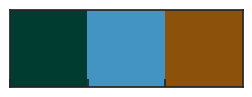

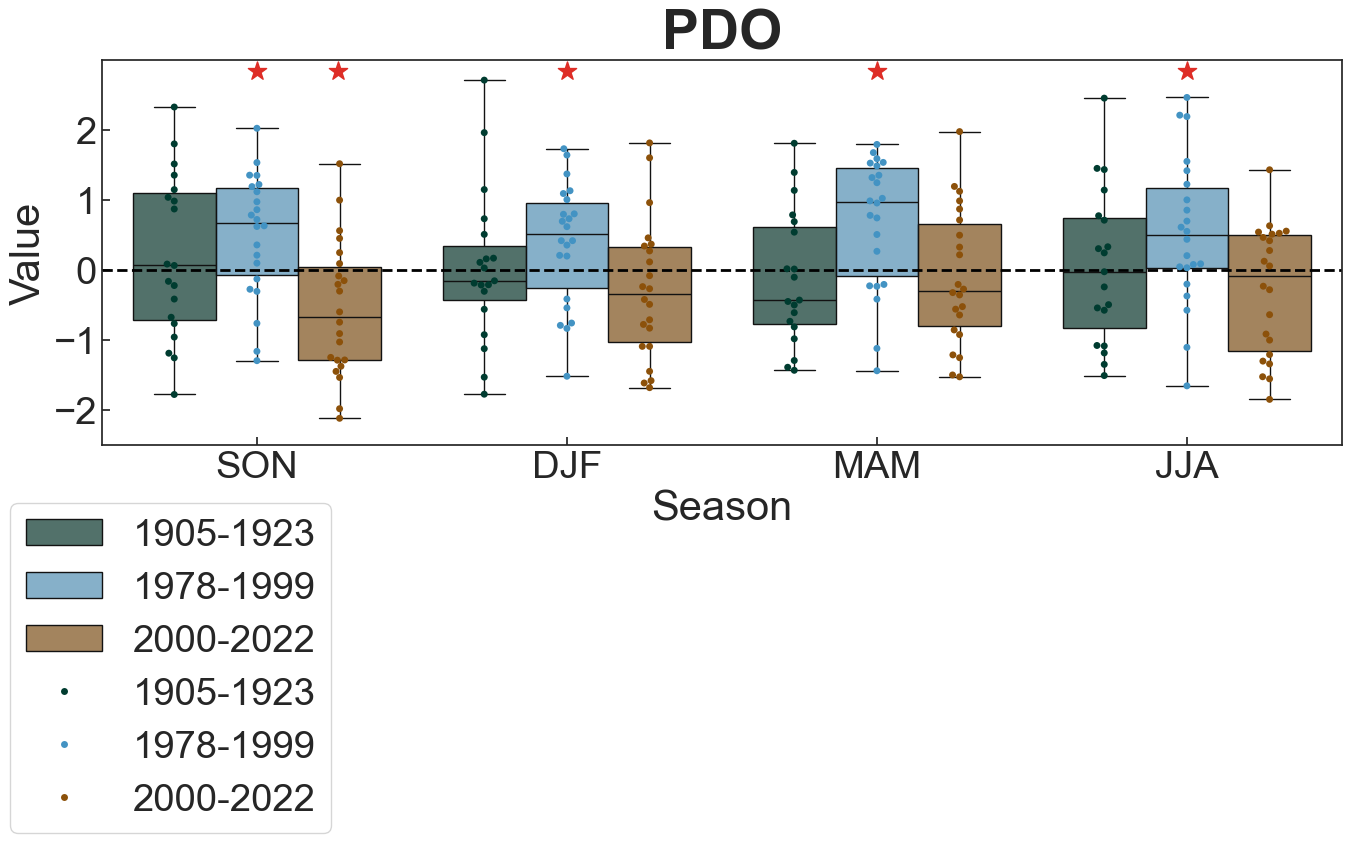

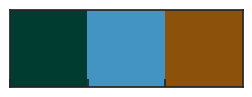

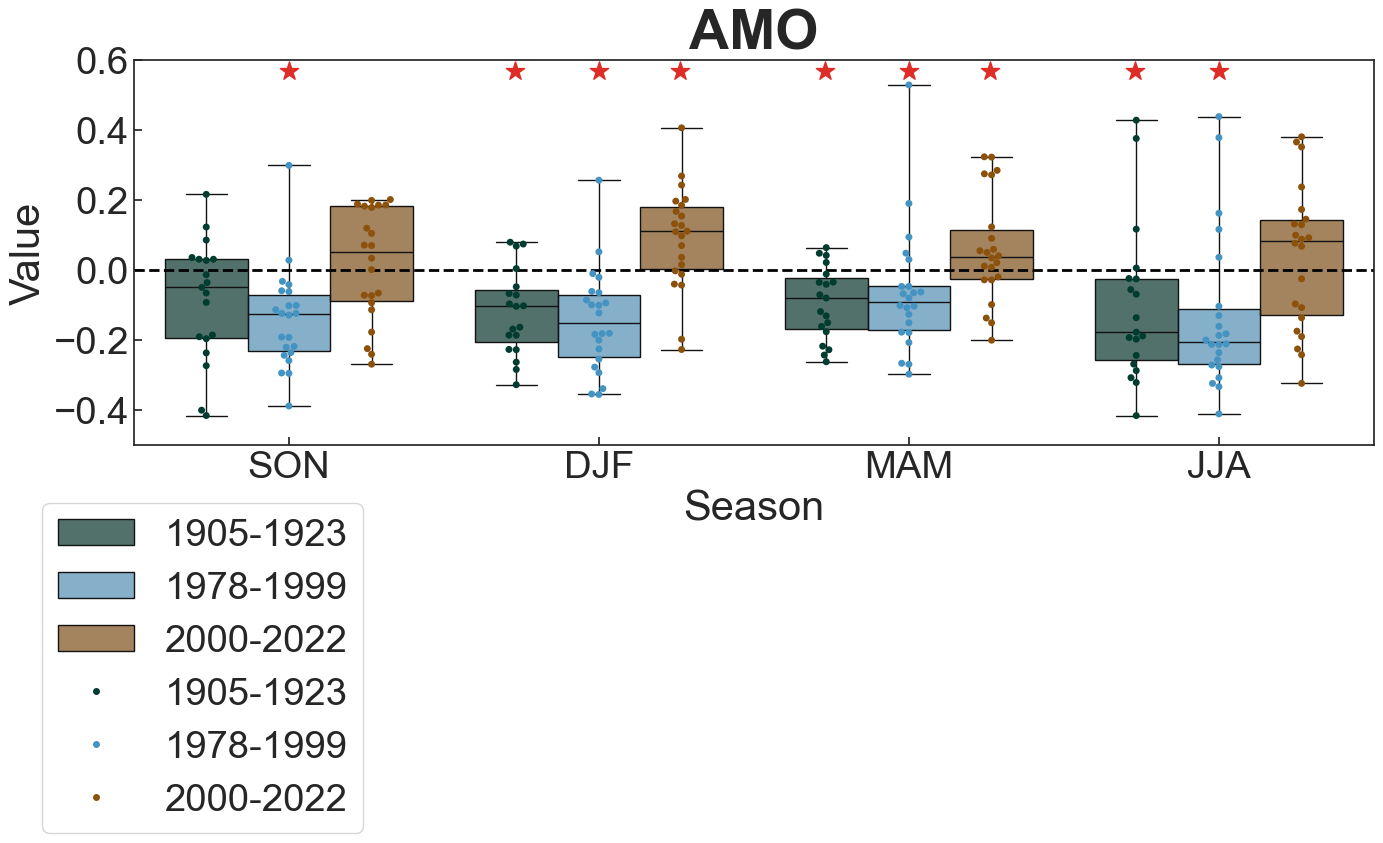

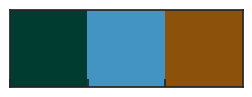

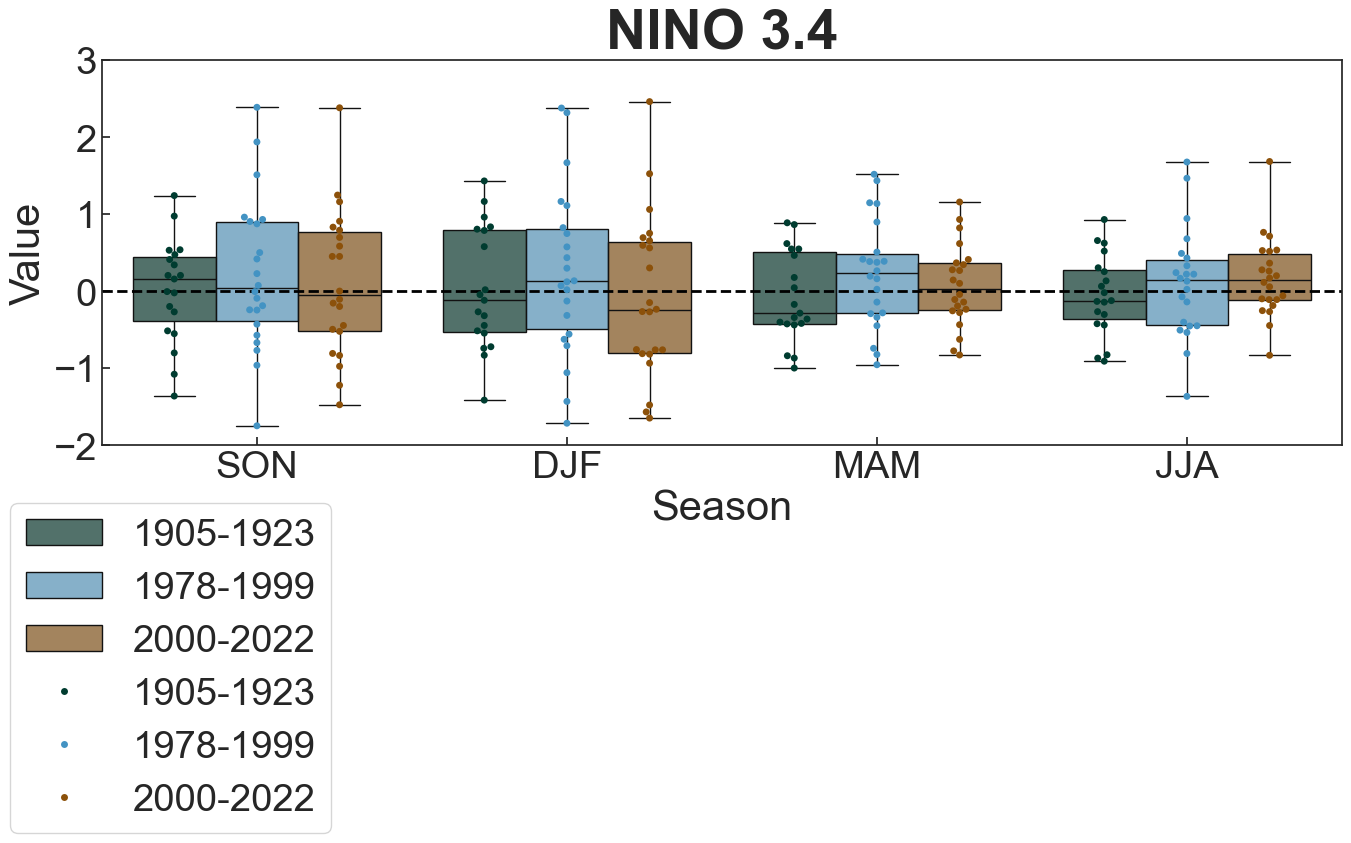

In [37]:
# Indices for pluvial/drought events
i_early20 = np.where( (yrs_seas>=1905) & (yrs_seas<=1923) )[0]
i_late20  = np.where( (yrs_seas>=1978) & (yrs_seas<=1999) )[0]
i_mega21  = np.where( (yrs_seas>=2000) & (yrs_seas<=2022) )[0]

# Exclusionary Years for KS Testing (unique for each event)
yrs_nonearly20 = np.setxor1d(yrs_seas,yrs_seas[i_early20]); i_nonearly20 = np.nonzero(np.in1d(yrs_seas,yrs_nonearly20))[0]
yrs_nonlate20  = np.setxor1d(yrs_seas,yrs_seas[i_late20]);  i_nonlate20  = np.nonzero(np.in1d(yrs_seas,yrs_nonlate20))[0]
yrs_nonmega21  = np.setxor1d(yrs_seas,yrs_seas[i_mega21]);  i_nonmega21  = np.nonzero(np.in1d(yrs_seas,yrs_nonmega21))[0]

# Save a palette to a variable:
new_pal = sns.color_palette(('#003c30','#4393c3','#8c510a'))
    
# PDO-----------------------------------------------------------------------------------------------------------------------------------------

# Use palplot and pass in the variable:
sns.palplot(new_pal)

# Baseline Info (mode name; IQR using all months, all seasons)
txt_mode='PDO'; mode_seas_ave=seas_ave_pdo.copy(); ymin=-2.5; ymax=3.0; ytick_vect=np.array([-2,-1,0,1,2])

# Pull out mode for events
# early pluvial
early_mode    = mode_seas_ave[:,i_early20].copy(); alt_early_mode = mode_seas_ave[:,i_nonearly20].copy()
# late pluvial
late_mode     = mode_seas_ave[:,i_late20].copy();  alt_late_mode  = mode_seas_ave[:,i_nonlate20].copy()
# 21st Cent Megadrought
mega_mode     = mode_seas_ave[:,i_mega21].copy();  alt_mega_mode  = mode_seas_ave[:,i_nonmega21].copy()

#alt_early_mode = mode_seas_ave[:,np.where(yrs_seas>=1871)[0]].copy()
#alt_late_mode  = mode_seas_ave[:,np.where(yrs_seas<=1871)[0]].copy()
#alt_mega_mode  = mode_seas_ave[:,np.where(yrs_seas<=1871)[0]].copy()

# 2-Sample KS-TEST
kst2samp_pval = np.zeros((3,np.size(all_seas_txt)))*np.nan
for n_seas in enumerate(all_seas_txt):
    # Early pluvial
    kst2samp_pval[0,n_seas[0]] = scipy.stats.ks_2samp(early_mode[n_seas[0],:],alt_early_mode[n_seas[0],:]).pvalue
    #kst2samp_pval[0,n_seas[0]] = scipy.stats.ks_1samp(early_mode[n_seas[0],:],stats.norm.cdf).pvalue
    # Late pluvial
    kst2samp_pval[1,n_seas[0]] = scipy.stats.ks_2samp(late_mode[n_seas[0],:],alt_late_mode[n_seas[0],:]).pvalue
    #kst2samp_pval[1,n_seas[0]] = scipy.stats.ks_1samp(late_mode[n_seas[0],:],stats.norm.cdf).pvalue
    # Megadrought
    kst2samp_pval[2,n_seas[0]] = scipy.stats.ks_2samp(mega_mode[n_seas[0],:],alt_mega_mode[n_seas[0],:]).pvalue
    #kst2samp_pval[2,n_seas[0]] = scipy.stats.ks_1samp(mega_mode[n_seas[0],:],stats.norm.cdf).pvalue

print(kst2samp_pval)

# Initialize dataframe for plotting
df_comp_var = pd.DataFrame(columns=('Event','Value','Season'),index=None)

# Seasonal loop
for n_seas in enumerate(all_seas_txt):
    # Current seasonal information
    seas_txt  = copy.deepcopy(n_seas[1])
    print(seas_txt)
          
    # Early Pluvial Loop
    for n_ev in np.arange(0,i_early20.size): 
        df_join1 = pd.DataFrame([['1905-1923',early_mode[n_seas[0],n_ev],seas_txt]],columns=['Event','Value','Season'])
        df_comp_var = pd.concat([df_comp_var, df_join1], ignore_index=True)

    # Late Pluvial Loop
    for n_ev in np.arange(0,i_late20.size): 
        df_join1 = pd.DataFrame([['1978-1999',late_mode[n_seas[0],n_ev],seas_txt]],columns=['Event','Value','Season'])
        df_comp_var = pd.concat([df_comp_var, df_join1], ignore_index=True)

    # Megadrought
    for n_ev in np.arange(0,i_late20.size): 
        df_join1 = pd.DataFrame([['2000-2022',mega_mode[n_seas[0],n_ev],seas_txt]],columns=['Event','Value','Season'])
        df_comp_var = pd.concat([df_comp_var, df_join1], ignore_index=True)

plt.figure(figsize=(16,5),facecolor="white")
sns.set_style("ticks",style_new)
ax = sns.boxplot(x="Season", y="Value", hue="Event", data=df_comp_var, whis=100, palette=new_pal)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))
#ax=plt.fill_between(np.arange(-0.5,4.5), pct25_mode, pct75_mode,color='grey',alpha=0.2)
plt.plot(np.array([-0.5,3.5]),np.array([-0.5,3.5])*0,linewidth=2,color='k',linestyle='--')
sns.swarmplot(data=df_comp_var, x="Season", y="Value", hue="Event", palette=new_pal,dodge=True)
plt.legend(loc='best', bbox_to_anchor=(0.1, 0., 0.1, -0.1))
#sns.swarmplot(data=df_comp_var, x="Season", y="Value", hue="Event", color=np.array([0.6,0.6,0.6]), dodge=True)
plt.xlim(-0.5,3.5)
# Plot significance
cnt_seas=0
for n_seas in enumerate(all_seas_txt):
    if kst2samp_pval[0,n_seas[0]]<=0.10:
        plt.scatter(cnt_seas-0.27,ymax*0.95, s=190, marker='*', c='#de2d26')
    if kst2samp_pval[1,n_seas[0]]<=0.10:
        plt.scatter(cnt_seas+0,ymax*0.95, s=190, marker='*', c='#de2d26')
    if kst2samp_pval[2,n_seas[0]]<=0.10:
        plt.scatter(cnt_seas+0.26,ymax*0.95, s=190, marker='*', c='#de2d26')
    cnt_seas=cnt_seas+1   
plt.ylim(ymin,ymax)
plt.yticks(ytick_vect)
ax=plt.title(txt_mode,font='arial',fontsize=40,fontweight='bold')
#plt.savefig('../figures/boxplot_'+txt_mode+'.pdf',format='pdf')

# AMO-----------------------------------------------------------------------------------------------------------------------------------------

# Use palplot and pass in the variable:
sns.palplot(new_pal)

# Baseline Info (mode name; IQR using all months, all seasons)
txt_mode='AMO'; mode_seas_ave=seas_ave_amo.copy(); ymin=-0.5; ymax=0.6; ytick_vect=np.array([-0.4,-0.2,0,0.2,0.4,0.6])

# Pull out mode for events
# early pluvial
early_mode    = mode_seas_ave[:,i_early20].copy(); alt_early_mode = mode_seas_ave[:,i_nonearly20].copy()
# late pluvial
late_mode     = mode_seas_ave[:,i_late20].copy();  alt_late_mode  = mode_seas_ave[:,i_nonlate20].copy()
# 21st Cent Megadrought
mega_mode     = mode_seas_ave[:,i_mega21].copy();  alt_mega_mode  = mode_seas_ave[:,i_nonmega21].copy()

# 2-Sample KS-TEST
kst2samp_pval = np.zeros((3,np.size(all_seas_txt)))*np.nan
for n_seas in enumerate(all_seas_txt):
    # Early pluvial
    kst2samp_pval[0,n_seas[0]] = scipy.stats.ks_2samp(early_mode[n_seas[0],:],ma.masked_invalid(alt_early_mode[n_seas[0],:])).pvalue
    # Late pluvial
    kst2samp_pval[1,n_seas[0]] = scipy.stats.ks_2samp(late_mode[n_seas[0],:],ma.masked_invalid(alt_late_mode[n_seas[0],:])).pvalue
    # Megadrought
    kst2samp_pval[2,n_seas[0]] = scipy.stats.ks_2samp(mega_mode[n_seas[0],:],ma.masked_invalid(alt_mega_mode[n_seas[0],:])).pvalue
print(kst2samp_pval)

# Initialize dataframe for plotting
df_comp_var = pd.DataFrame(columns=('Event','Value','Season'),index=None)

# Seasonal loop
for n_seas in enumerate(all_seas_txt):
    # Current seasonal information
    seas_txt  = copy.deepcopy(n_seas[1])
    print(seas_txt)
          
    # Early Pluvial Loop
    for n_ev in np.arange(0,i_early20.size): 
        df_join1 = pd.DataFrame([['1905-1923',early_mode[n_seas[0],n_ev],seas_txt]],columns=['Event','Value','Season'])
        df_comp_var = pd.concat([df_comp_var, df_join1], ignore_index=True)

    # Late Pluvial Loop
    for n_ev in np.arange(0,i_late20.size): 
        df_join1 = pd.DataFrame([['1978-1999',late_mode[n_seas[0],n_ev],seas_txt]],columns=['Event','Value','Season'])
        df_comp_var = pd.concat([df_comp_var, df_join1], ignore_index=True)

    # Megadrought
    for n_ev in np.arange(0,i_late20.size): 
        df_join1 = pd.DataFrame([['2000-2022',mega_mode[n_seas[0],n_ev],seas_txt]],columns=['Event','Value','Season'])
        df_comp_var = pd.concat([df_comp_var, df_join1], ignore_index=True)

plt.figure(figsize=(16,5),facecolor="white")
sns.set_style("ticks",style_new)
ax = sns.boxplot(x="Season", y="Value", hue="Event", data=df_comp_var, whis=100, palette=new_pal)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))
#ax=plt.fill_between(np.arange(-0.5,4.5), pct25_mode, pct75_mode,color='grey',alpha=0.2)
plt.plot(np.array([-0.5,3.5]),np.array([-0.5,3.5])*0,linewidth=2,color='k',linestyle='--')
sns.swarmplot(data=df_comp_var, x="Season", y="Value", hue="Event", palette=new_pal,dodge=True)
plt.legend(loc='best', bbox_to_anchor=(0.1, 0., 0.1, -0.1))
#sns.swarmplot(data=df_comp_var, x="Season", y="Value", hue="Event", color=np.array([0.6,0.6,0.6]), dodge=True)
plt.xlim(-0.5,3.5)
# Plot significance
cnt_seas=0
for n_seas in enumerate(all_seas_txt):
    if kst2samp_pval[0,n_seas[0]]<=0.10:
        plt.scatter(cnt_seas-0.27,ymax*0.95, s=190, marker='*', c='#de2d26')
    if kst2samp_pval[1,n_seas[0]]<=0.10:
        plt.scatter(cnt_seas+0,ymax*0.95, s=190, marker='*', c='#de2d26')
    if kst2samp_pval[2,n_seas[0]]<=0.10:
        plt.scatter(cnt_seas+0.26,ymax*0.95, s=190, marker='*', c='#de2d26')
    cnt_seas=cnt_seas+1   
plt.ylim(ymin,ymax)
plt.yticks(ytick_vect)
ax=plt.title(txt_mode,font='arial',fontsize=40,fontweight='bold')
#plt.savefig('../figures/boxplot_'+txt_mode+'.pdf',format='pdf')

# NINO3.4-----------------------------------------------------------------------------------------------------------------------------------------

# Use palplot and pass in the variable:
sns.palplot(new_pal)

# Baseline Info (mode name; IQR using all months, all seasons)
txt_mode='NINO 3.4'; mode_seas_ave=seas_ave_nino34.copy(); ymin=-2; ymax=3; ytick_vect=np.array([-2,-1,0,1,2,3])

# Pull out mode for events
# early pluvial
early_mode    = mode_seas_ave[:,i_early20].copy(); alt_early_mode = mode_seas_ave[:,i_nonearly20].copy()
# late pluvial
late_mode     = mode_seas_ave[:,i_late20].copy();  alt_late_mode  = mode_seas_ave[:,i_nonlate20].copy()
# 21st Cent Megadrought
mega_mode     = mode_seas_ave[:,i_mega21].copy();  alt_mega_mode  = mode_seas_ave[:,i_nonmega21].copy()

# 2-Sample KS-TEST
kst2samp_pval = np.zeros((3,np.size(all_seas_txt)))*np.nan
for n_seas in enumerate(all_seas_txt):
    # Early pluvial
    kst2samp_pval[0,n_seas[0]] = scipy.stats.ks_2samp(early_mode[n_seas[0],:],ma.masked_invalid(alt_early_mode[n_seas[0],:])).pvalue
    # Late pluvial
    kst2samp_pval[1,n_seas[0]] = scipy.stats.ks_2samp(late_mode[n_seas[0],:],ma.masked_invalid(alt_late_mode[n_seas[0],:])).pvalue
    # Megadrought
    kst2samp_pval[2,n_seas[0]] = scipy.stats.ks_2samp(mega_mode[n_seas[0],:],ma.masked_invalid(alt_mega_mode[n_seas[0],:])).pvalue
print(kst2samp_pval)

# Initialize dataframe for plotting
df_comp_var = pd.DataFrame(columns=('Event','Value','Season'),index=None)

# Seasonal loop
for n_seas in enumerate(all_seas_txt):
    # Current seasonal information
    seas_txt  = copy.deepcopy(n_seas[1])
    print(seas_txt)
          
    # Early Pluvial Loop
    for n_ev in np.arange(0,i_early20.size): 
        df_join1 = pd.DataFrame([['1905-1923',early_mode[n_seas[0],n_ev],seas_txt]],columns=['Event','Value','Season'])
        df_comp_var = pd.concat([df_comp_var, df_join1], ignore_index=True)

    # Late Pluvial Loop
    for n_ev in np.arange(0,i_late20.size): 
        df_join1 = pd.DataFrame([['1978-1999',late_mode[n_seas[0],n_ev],seas_txt]],columns=['Event','Value','Season'])
        df_comp_var = pd.concat([df_comp_var, df_join1], ignore_index=True)

    # Megadrought
    for n_ev in np.arange(0,i_late20.size): 
        df_join1 = pd.DataFrame([['2000-2022',mega_mode[n_seas[0],n_ev],seas_txt]],columns=['Event','Value','Season'])
        df_comp_var = pd.concat([df_comp_var, df_join1], ignore_index=True)

plt.figure(figsize=(16,5),facecolor="white")
sns.set_style("ticks",style_new)
ax = sns.boxplot(x="Season", y="Value", hue="Event", data=df_comp_var, whis=100, palette=new_pal)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))
#ax=plt.fill_between(np.arange(-0.5,4.5), pct25_mode, pct75_mode,color='grey',alpha=0.2)
plt.plot(np.array([-0.5,3.5]),np.array([-0.5,3.5])*0,linewidth=2,color='k',linestyle='--')
sns.swarmplot(data=df_comp_var, x="Season", y="Value", hue="Event", palette=new_pal,dodge=True)
plt.legend(loc='best', bbox_to_anchor=(0.1, 0., 0.1, -0.1))
#sns.swarmplot(data=df_comp_var, x="Season", y="Value", hue="Event", color=np.array([0.6,0.6,0.6]), dodge=True)
plt.xlim(-0.5,3.5)
# Plot significance
cnt_seas=0
for n_seas in enumerate(all_seas_txt):
    if kst2samp_pval[0,n_seas[0]]<=0.10:
        plt.scatter(cnt_seas-0.27,ymax*0.97, s=190, marker='*', c='#de2d26')
    if kst2samp_pval[1,n_seas[0]]<=0.10:
        plt.scatter(cnt_seas+0,ymax*0.97, s=190, marker='*', c='#de2d26')
    if kst2samp_pval[2,n_seas[0]]<=0.10:
        plt.scatter(cnt_seas+0.26,ymax*0.97, s=190, marker='*', c='#de2d26')
    cnt_seas=cnt_seas+1   
plt.ylim(ymin,ymax)
plt.yticks(ytick_vect)
ax=plt.title(txt_mode,font='arial',fontsize=40,fontweight='bold')
#plt.savefig('../figures/boxplot_'+txt_mode+'.pdf',format='pdf')


## Load PHYDA reconstruction and drought/pluvial stats for each individual ensemble member
* pool all ensemble information for analysis

In [39]:
# Load All Ensemble Members: NINO34, PDO, AMO, SWNA PDSI reconstruction
df_phyda_sm      = pd.read_csv('../data/ensphyda/soilmoist/ensphyda_swna_pdsi_scaled_detrend.csv',index_col='Year')
df_phyda_ninoDJF = pd.read_csv('../data/ensphyda/indices/ensphyda_ninoDJF_scaled_detrend.csv',index_col='Year')
df_phyda_pdoDJF  = pd.read_csv('../data/ensphyda/indices/ensphyda_pdoDJF_scaled_detrend.csv',index_col='Year')
df_phyda_amoJJA  = pd.read_csv('../data/ensphyda/indices/ensphyda_amoJJA_scaled_detrend.csv',index_col='Year')

# Pull out variables into Numpy Arrays
yr_phyda        = np.array(df_phyda_sm.index)
sm_phyda        = np.array(df_phyda_sm.values)
ninoDJF_phyda   = np.array(df_phyda_ninoDJF.values)
pdoDJF_phyda    = np.array(df_phyda_pdoDJF.values)
amoJJA_phyda    = np.array(df_phyda_amoJJA.values)

# Correlations
print('Pearson''s r (JJA SWNA PDSI vs DJF PDO): ')
print(scipy.stats.pearsonr(pdoDJF_phyda.flatten(),sm_phyda.flatten()))
print('--------------------------------------------------------------------')
print('Pearson''s r (JJA SWNA PDSI vs DJF NINO 3.4): ')
print(scipy.stats.pearsonr(ninoDJF_phyda.flatten(),sm_phyda.flatten()))
print('--------------------------------------------------------------------')
print('Pearson''s r (JJA SWNA PDSI vs JJA AMO): ')
print(scipy.stats.pearsonr(amoJJA_phyda.flatten(),sm_phyda.flatten()))
print('--------------------------------------------------------------------')
print('Pearson''s r (DJF PDO vs DJF NINO 3.4): ')
print(scipy.stats.pearsonr(pdoDJF_phyda.flatten(),ninoDJF_phyda.flatten()))
print('--------------------------------------------------------------------')
print('Pearson''s r (DJF PDO vs JJA AMO): ')
print(scipy.stats.pearsonr(pdoDJF_phyda.flatten(),amoJJA_phyda.flatten()))
print('--------------------------------------------------------------------')
print('Pearson''s r (DJF NINO 3.4 vs JJA AMO): ')
print(scipy.stats.pearsonr(ninoDJF_phyda.flatten(),amoJJA_phyda.flatten()))
print('--------------------------------------------------------------------')

print('    ')

# Storage Arrays
ensemb_parkcorr    = np.zeros((100))*np.nan
# Drought Statistics
allens_smJJA_drght   = []
allens_ninoDJF_drght = []
allens_pdoDJF_drght  = []
allens_amoJJA_drght  = []
# Pluvial Statistics
allens_smJJA_pluv    = []
allens_ninoDJF_pluv  = []
allens_pdoDJF_pluv   = []
allens_amoJJA_pluv   = []

# Specific Pluvial Events
allens_earlypluv_smJJA   = [];     allens_latepluv_smJJA   = []
allens_earlypluv_pdoDJF  = [];     allens_latepluv_pdoDJF  = []
allens_earlypluv_ninoDJF = [];     allens_latepluv_ninoDJF = []
allens_earlypluv_amoJJA  = [];     allens_latepluv_amoJJA  = []

# Loop Through Each Ensemble Member
for n_ens in np.arange(0,100):
    print('Processing ENSEMBLE #'+str(n_ens+1))
    
    # Current Ensemble Soil Moisture
    ens_smJJA   = sm_phyda[:,n_ens].copy() 
    ens_ninoDJF = ninoDJF_phyda[:,n_ens].copy() 
    ens_pdoDJF  = pdoDJF_phyda[:,n_ens].copy() 
    ens_amoJJA  = amoJJA_phyda[:,n_ens].copy() 
    
    # Correlation with Park's Recon
    ensemb_parkcorr[n_ens],pval = scipy.stats.pearsonr(ens_smJJA,sm_obs_all[np.where(sm_obs_yr<=2000)])
    
    # Load Current Ensemble Drought/Pluv Stats
    df_drought_phyda = pd.read_csv('../data/ensphyda/statsdrght/phyda_ens#'+str(n_ens+1)+'_extdrght.csv')
    df_pluvial_phyda = pd.read_csv('../data/ensphyda/statspluv/phyda_ens#'+str(n_ens+1)+'_extpluv.csv')

    # Pull out duration/cumulative severity
    dur_pluv_phyda    = np.array(df_pluvial_phyda['Duration']) 
    dur_drgt_phyda    = np.array(df_drought_phyda['Duration'])
    cumsum_pluv_phyda = np.array(df_pluvial_phyda['CumSum'])   
    cumsum_drgt_phyda = np.array(df_drought_phyda['CumSum'])
    
    # Pull out list of first and last year of pluvial events-------------------------------------------------------
    pluv_yrbeg_phyda  = np.array(df_pluvial_phyda.FirstYr[df_pluvial_phyda['Duration']>=min_len])
    pluv_yrend_phyda  = np.array(df_pluvial_phyda.LastYr[df_pluvial_phyda['Duration']>=min_len])
    pluv_length_phyda = np.array(df_pluvial_phyda.Duration[df_pluvial_phyda['Duration']>=min_len])
    pluv_yrterm_phyda = pluv_yrend_phyda+1
    
    # Find Early and Late 20th Century Pluvial Events
    i_phyda_early = np.where( (pluv_yrbeg_phyda>=1900) & (pluv_yrbeg_phyda<=1925) )[0]
    i_phyda_late  = np.where( (pluv_yrbeg_phyda>=1950) & (pluv_yrbeg_phyda<=2000) )[0]
    
    # Years/Indices for these events
    ens_yrs_earlypluv = np.arange(pluv_yrbeg_phyda[i_phyda_early],pluv_yrend_phyda[i_phyda_early]+1) 
    ens_yrs_latepluv  = np.arange(pluv_yrbeg_phyda[i_phyda_late],pluv_yrend_phyda[i_phyda_late]+1) 
    i_ens_earlypluv   = np.nonzero(np.in1d(yr_phyda,ens_yrs_earlypluv))[0]
    i_ens_latepluv    = np.nonzero(np.in1d(yr_phyda,ens_yrs_latepluv))[0]
    
    # Pull out and store values for these events
    # soil moisture
    allens_earlypluv_smJJA = np.hstack((allens_earlypluv_smJJA,ens_smJJA[i_ens_earlypluv]))
    allens_latepluv_smJJA  = np.hstack((allens_latepluv_smJJA,ens_smJJA[i_ens_latepluv]))
    # DJF PDO
    allens_earlypluv_pdoDJF = np.hstack((allens_earlypluv_pdoDJF,ens_pdoDJF[i_ens_earlypluv]))
    allens_latepluv_pdoDJF  = np.hstack((allens_latepluv_pdoDJF,ens_pdoDJF[i_ens_latepluv]))
    # DJF NINO 3.4
    allens_earlypluv_ninoDJF = np.hstack((allens_earlypluv_ninoDJF,ens_ninoDJF[i_ens_earlypluv]))
    allens_latepluv_ninoDJF  = np.hstack((allens_latepluv_ninoDJF,ens_ninoDJF[i_ens_latepluv]))
    # JJA AMO
    allens_earlypluv_amoJJA = np.hstack((allens_earlypluv_amoJJA,ens_amoJJA[i_ens_earlypluv]))
    allens_latepluv_amoJJA  = np.hstack((allens_latepluv_amoJJA,ens_amoJJA[i_ens_latepluv]))    
    
    # Loop through pluvial events
    for n_pluv in np.arange(0,pluv_yrbeg_phyda.size):  
        # All years, current pluvial
        currpluv_yrs_phyda = np.arange(pluv_yrbeg_phyda[n_pluv],pluv_yrend_phyda[n_pluv]+1)
    
        # If first event, use this to initialize all years array
        if n_pluv==0:
            allpluv_yrs_phyda = currpluv_yrs_phyda.copy()
        # Otherwise, append
        else:
            allpluv_yrs_phyda = np.hstack((allpluv_yrs_phyda,currpluv_yrs_phyda))
        
    # Pull out list of first and last year of drought events-------------------------------------------------------
    drgt_yrbeg_phyda  = np.array(df_drought_phyda.FirstYr[df_drought_phyda['Duration']>=min_len])
    drgt_yrend_phyda  = np.array(df_drought_phyda.LastYr[df_drought_phyda['Duration']>=min_len])
    drgt_length_phyda = np.array(df_drought_phyda.Duration[df_drought_phyda['Duration']>=min_len])
    drgt_yrterm_phyda = drgt_yrend_phyda+1
    
    # Loop through pluvial events
    for n_drgt in np.arange(0,drgt_yrbeg_phyda.size):  
        # All years, current pluvial
        currdrgt_yrs_phyda = np.arange(drgt_yrbeg_phyda[n_drgt],drgt_yrend_phyda[n_drgt]+1)
    
        # If first event, use this to initialize all years array
        if n_drgt==0:
            alldrgt_yrs_phyda = currdrgt_yrs_phyda.copy()
        # Otherwise, append
        else:
            alldrgt_yrs_phyda = np.hstack((alldrgt_yrs_phyda,currdrgt_yrs_phyda))
        
    # Indices for drought and pluvial years
    i_drght_yrs = np.nonzero(np.in1d(yr_phyda,alldrgt_yrs_phyda))[0]
    i_pluv_yrs  = np.nonzero(np.in1d(yr_phyda,allpluv_yrs_phyda))[0]
    
    # Store All Ensemble Information: Drought
    allens_smJJA_drght   = np.hstack((allens_smJJA_drght,ens_smJJA[i_drght_yrs]))
    allens_ninoDJF_drght = np.hstack((allens_ninoDJF_drght,ens_ninoDJF[i_drght_yrs]))
    allens_pdoDJF_drght  = np.hstack((allens_pdoDJF_drght,ens_pdoDJF[i_drght_yrs]))
    allens_amoJJA_drght  = np.hstack((allens_amoJJA_drght,ens_amoJJA[i_drght_yrs]))    
    
    # Store All Ensemble Information: Pluvial
    allens_smJJA_pluv    = np.hstack((allens_smJJA_pluv,ens_smJJA[i_pluv_yrs]))
    allens_ninoDJF_pluv  = np.hstack((allens_ninoDJF_pluv,ens_ninoDJF[i_pluv_yrs]))
    allens_pdoDJF_pluv   = np.hstack((allens_pdoDJF_pluv,ens_pdoDJF[i_pluv_yrs]))
    allens_amoJJA_pluv   = np.hstack((allens_amoJJA_pluv,ens_amoJJA[i_pluv_yrs]))    
    

Pearsons r (JJA SWNA PDSI vs DJF PDO): 
PearsonRResult(statistic=0.6774046124491362, pvalue=0.0)
--------------------------------------------------------------------
Pearsons r (JJA SWNA PDSI vs DJF NINO 3.4): 
PearsonRResult(statistic=0.4005639417259117, pvalue=0.0)
--------------------------------------------------------------------
Pearsons r (JJA SWNA PDSI vs JJA AMO): 
PearsonRResult(statistic=0.21381302355014778, pvalue=0.0)
--------------------------------------------------------------------
Pearsons r (DJF PDO vs DJF NINO 3.4): 
PearsonRResult(statistic=0.4365732005604587, pvalue=0.0)
--------------------------------------------------------------------
Pearsons r (DJF PDO vs JJA AMO): 
PearsonRResult(statistic=0.2820501402614729, pvalue=0.0)
--------------------------------------------------------------------
Pearsons r (DJF NINO 3.4 vs JJA AMO): 
PearsonRResult(statistic=0.48476151366475123, pvalue=0.0)
--------------------------------------------------------------------
    


## Soil Moisture and Climate Indices Arrays for Plotting

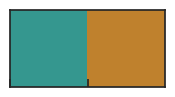

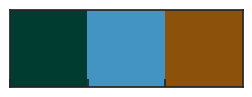

In [40]:
# Years for Observed Events
yrs_earlypluv = np.arange(1905,1923+1)
yrs_latepluv  = np.arange(1978,1999+1)
yrs_mega21st  = np.arange(2000,2022+1)

# Soil Moisture for Events
i_sm_alldrght  = np.nonzero(np.in1d(sm_obs_yr,alldrgt_yrs))[0]
i_sm_allpluv   = np.nonzero(np.in1d(sm_obs_yr,allpluv_yrs))[0]
i_sm_earlypluv = np.nonzero(np.in1d(sm_obs_yr,yrs_earlypluv))[0]
i_sm_latepluv  = np.nonzero(np.in1d(sm_obs_yr,yrs_latepluv))[0]
i_sm_mega21st  = np.nonzero(np.in1d(sm_obs_yr,yrs_mega21st))[0]
obs_sm_alldrght  = sm_obs_all[i_sm_alldrght].copy()
obs_sm_allpluv  = sm_obs_all[i_sm_allpluv].copy()
obs_sm_earlypluv = sm_obs_all[i_sm_earlypluv].copy()
obs_sm_latepluv  = sm_obs_all[i_sm_latepluv].copy()
obs_sm_mega21st  = sm_obs_all[i_sm_mega21st].copy()

# Climate Indices for Events
i_sm_earlypluv       = np.nonzero(np.in1d(yrs_seas,yrs_earlypluv))[0]
i_sm_latepluv        = np.nonzero(np.in1d(yrs_seas,yrs_latepluv))[0]
i_sm_mega21st        = np.nonzero(np.in1d(yrs_seas,yrs_mega21st))[0]
# PDO
obs_pdoDJF_earlypluv = seas_ave_pdo[1,i_sm_earlypluv].copy()
obs_pdoDJF_latepluv  = seas_ave_pdo[1,i_sm_latepluv].copy()
obs_pdoDJF_mega21st  = seas_ave_pdo[1,i_sm_mega21st].copy()
# NINO 3.4
obs_ninoDJF_earlypluv = seas_ave_nino34[1,i_sm_earlypluv].copy()
obs_ninoDJF_latepluv  = seas_ave_nino34[1,i_sm_latepluv].copy()
obs_ninoDJF_mega21st  = seas_ave_nino34[1,i_sm_mega21st].copy()
# AMO
obs_amoJJA_earlypluv = seas_ave_amo[3,i_sm_earlypluv].copy()
obs_amoJJA_latepluv  = seas_ave_amo[3,i_sm_latepluv].copy()
obs_amoJJA_mega21st  = seas_ave_amo[3,i_sm_mega21st].copy()

# PHYDA Event Labels
lab_pluvs = np.repeat(np.array(['All Pluvials']),allens_smJJA_pluv.size)
lab_drght = np.repeat(np.array(['All Droughts']),allens_smJJA_drght.size)
lab_all   = np.hstack((lab_pluvs,lab_drght))

# PHYDA Values Associated With These Events
allens_sm_all      = np.hstack((allens_smJJA_pluv,allens_smJJA_drght))
allens_ninoDJF_all = np.hstack((allens_ninoDJF_pluv,allens_ninoDJF_drght))
allens_pdoDJF_all  = np.hstack((allens_pdoDJF_pluv,allens_pdoDJF_drght))
allens_amoJJA_all  = np.hstack((allens_amoJJA_pluv,allens_amoJJA_drght))

# Color Palette
old_pal = sns.color_palette(('#003c30','#4393c3','#8c510a'))
new_pal = sns.color_palette(('#35978f','#bf812d'))
sns.palplot(new_pal)
sns.palplot(old_pal)


## Create Density and Boxplots for Comparisons Between Droughts and Pluvials

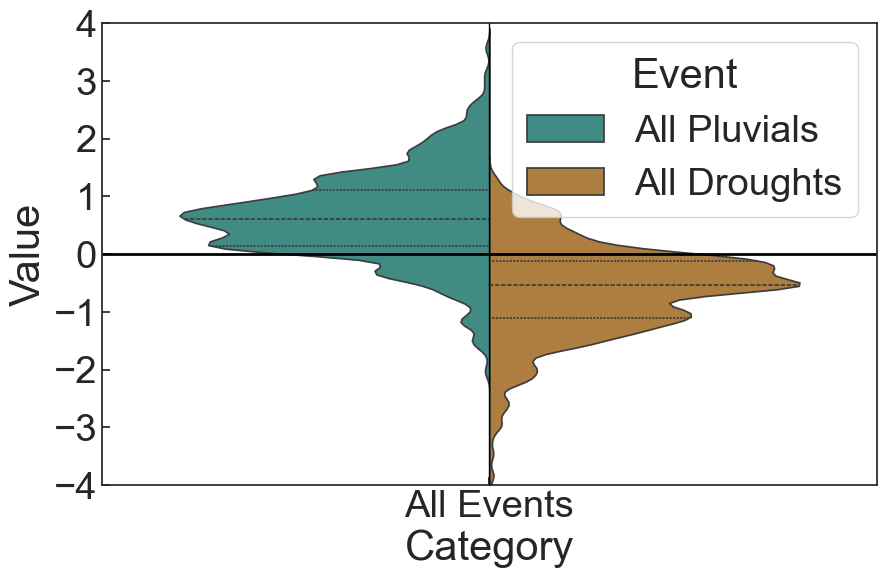

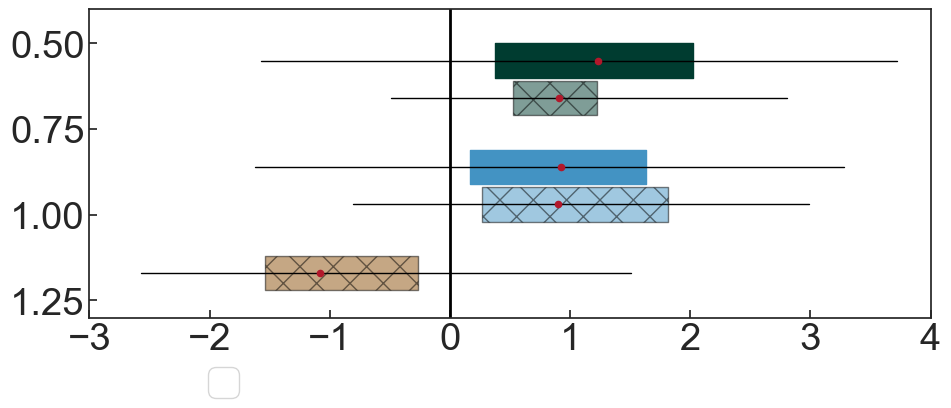

In [41]:
# Variables to Plot: Soil Moisture
var_name        = 'smJJA'; x_ticks=np.arange(-4,4+1,1); x_ticks_box=np.arange(-3,4+1,1)
allens_var      = allens_sm_all.copy(); 
earlypluv_phyda = allens_earlypluv_smJJA.copy()
latepluv_phyda  = allens_latepluv_smJJA.copy()
earlypluv_obs   = obs_sm_earlypluv 
latepluv_obs    = obs_sm_latepluv  
mega21st_obs    = obs_sm_mega21st  

# Variable to Plot: DJF PDO
#var_name        = 'pdoDJF'; x_ticks=np.arange(-3,4+1,1); x_ticks_box=np.arange(-3,3+1,1)
#allens_var      = allens_pdoDJF_all.copy(); 
#earlypluv_phyda = allens_earlypluv_pdoDJF.copy()
#latepluv_phyda  = allens_latepluv_pdoDJF.copy()
#earlypluv_obs   = obs_pdoDJF_earlypluv 
#latepluv_obs    = obs_pdoDJF_latepluv  
#mega21st_obs    = obs_pdoDJF_mega21st  

# Variable to Plot: DJF NINO 3.4
#var_name        = 'ninoDJF'; x_ticks=np.arange(-2,2+1,1); x_ticks_box=np.arange(-2,3+1,1)
#allens_var      = allens_ninoDJF_all.copy(); 
#earlypluv_phyda = allens_earlypluv_ninoDJF.copy()
#latepluv_phyda  = allens_latepluv_ninoDJF.copy()
#earlypluv_obs   = obs_ninoDJF_earlypluv 
#latepluv_obs    = obs_ninoDJF_latepluv  
#mega21st_obs    = obs_ninoDJF_mega21st  

# Variable to Plot: AMO JJA
#var_name        = 'amoJJA'; x_ticks=np.arange(-1.0,0.75+0.25,0.25); x_ticks_box=np.arange(-1.0,1.0+0.5,0.5)
#allens_var      = allens_amoJJA_all.copy(); 
#earlypluv_phyda = allens_earlypluv_amoJJA.copy()
#latepluv_phyda  = allens_latepluv_amoJJA.copy()
#earlypluv_obs   = obs_amoJJA_earlypluv 
#latepluv_obs    = obs_amoJJA_latepluv  
#mega21st_obs    = obs_amoJJA_mega21st  

# Initialize dataframe for PHYDA plotting
df_comp_var = pd.DataFrame(columns=('Event','Value','Category'),index=None)

# Populate Dataframe
df_comp_var['Event']    = lab_all
df_comp_var['Value']    = allens_var
df_comp_var['Category'] = 'All Events'

# Locations of Pluvial and Drought Events
i_allpluv = np.where(df_comp_var.Event=='All Pluvials')[0]
i_alldght = np.where(df_comp_var.Event=='All Droughts')[0]

# Figure
#plt.figure(figsize=(8,7))
plt.figure(figsize=(10,6))
sns.violinplot(data=df_comp_var, y="Value", hue="Event", x="Category", gap=0.0, split=True, palette=new_pal,inner="quart")
plt.plot((0,0),(-4,4),'-', color='k', linewidth=1)
plt.plot((-1,1),(0,0),'-', color='k', linewidth=2)
#plt.ylim(-4,4)
plt.xlim(-0.5,0.5)
plt.yticks(x_ticks)
plt.ylim(np.min(x_ticks),np.max(x_ticks))
plt.savefig('../figures/phyda_pluv_vs_drght_'+var_name+'.pdf',format='pdf')

# MODERN EVENT FIGURE-------------------------------------------------------------------------------------------------------
plt.figure(figsize=(10,5))
# PHYDA EARLY 20TH PLUVIAL
box_top = 0.5; box_bot = 0.6;
box_min = np.percentile(earlypluv_phyda,25); box_max = np.percentile(earlypluv_phyda,75)
line_min = np.min(earlypluv_phyda); line_max = np.max(earlypluv_phyda); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#003c30',alpha=1,zorder=0)
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.scatter(np.median(earlypluv_phyda),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# OBS EARLY 20TH PLUVIAL
box_top = box_top+0.11; box_bot = box_bot+0.11;
box_min = np.percentile(earlypluv_obs,25); box_max = np.percentile(earlypluv_obs,75)
line_min = np.min(earlypluv_obs); line_max = np.max(earlypluv_obs); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#003c30',alpha=0.5,zorder=0,hatch='x',edgecolor='k')
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.scatter(np.median(earlypluv_obs),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# PHYDA LATE 20TH PLUVIAL
box_top = box_top+0.2; box_bot = box_bot+0.2;
box_min = np.percentile(latepluv_phyda,25); box_max = np.percentile(latepluv_phyda,75)
line_min = np.min(latepluv_phyda); line_max = np.max(latepluv_phyda); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#4393c3',alpha=1,zorder=0)
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.scatter(np.median(latepluv_phyda),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# OBS LATE 20TH PLUVIAL
box_top = box_top+0.11; box_bot = box_bot+0.11;
box_min = np.percentile(latepluv_obs,25); box_max = np.percentile(latepluv_obs,75)
line_min = np.min(latepluv_obs); line_max = np.max(latepluv_obs); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#4393c3',alpha=0.5,zorder=0,hatch='x',edgecolor='k')
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.scatter(np.median(latepluv_obs),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# OBS 21ST CENT MEGADROUGHT
box_top = box_top+0.2; box_bot = box_bot+0.2;
box_min = np.percentile(mega21st_obs,25); box_max = np.percentile(mega21st_obs,75)
line_min = np.min(mega21st_obs); line_max = np.max(mega21st_obs); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#8c510a',alpha=0.5,zorder=0,hatch='x',edgecolor='k')
plt.scatter(np.median(mega21st_obs),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# Other Figure Formatting
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.ylim(1.3,0.4)
plt.plot((0,0),(1.3,-0.5),'-', color='k', linewidth=2)
#plt.xlim(-4,4)
#plt.xticks(np.arange(-4,5))
plt.xticks(x_ticks_box)
plt.xlim(np.min(x_ticks_box),np.max(x_ticks_box))
#plt.xlim(-2.5,3)
plt.legend(loc='best', bbox_to_anchor=(0.1, 0., 0.1, -0.1))
plt.tight_layout()
plt.savefig('../figures/phyda_vs_smrec_events_'+var_name+'.pdf',format='pdf')


## Find overlapping Extended drought/pluvial years between PHYDA and PARK Recon

PHYDA Correlation


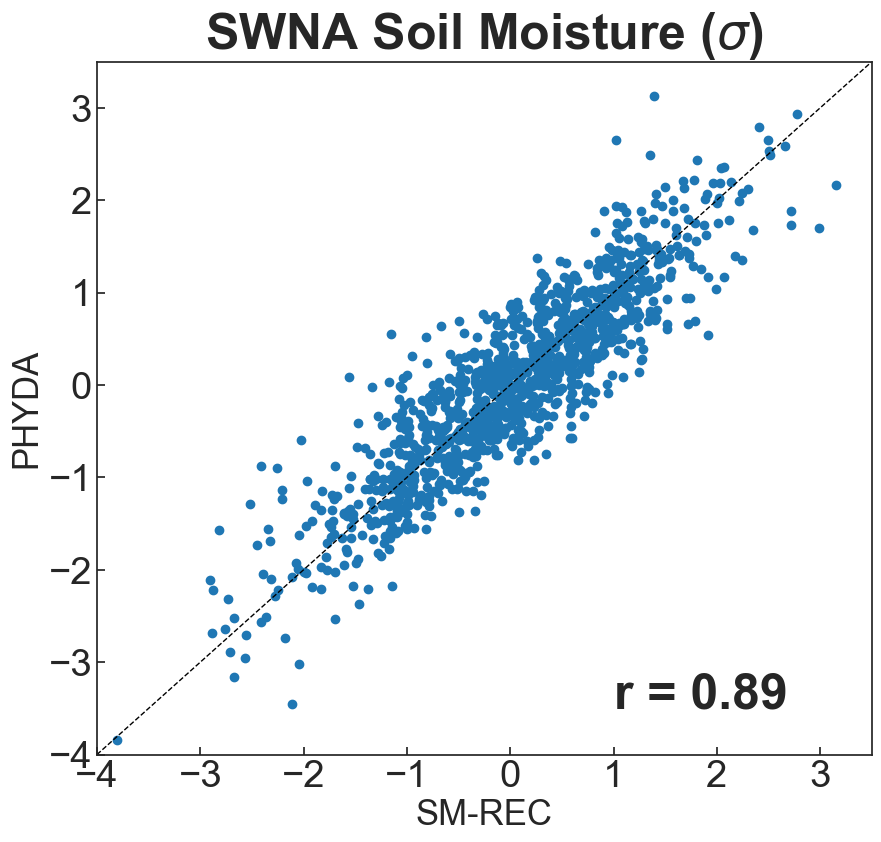

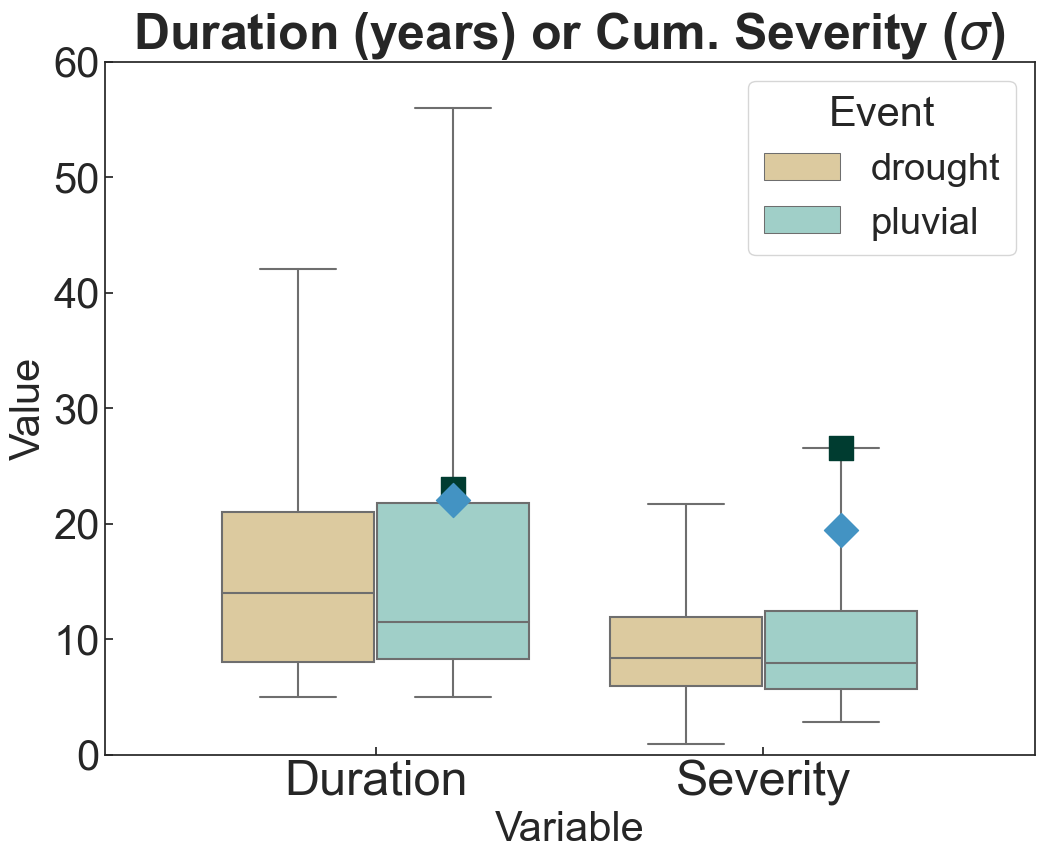

In [320]:
# Trim Recon To Same Period as PHYDA (800-2000)
park_rec_trim = sm_obs_all[np.where(sm_obs_yr<=2000)].copy()

print('PHYDA Correlation')
rval,pval=scipy.stats.pearsonr(park_rec_trim,sm_phyda_all)
rval_txt = np.round((rval*100))/100

plt.figure(figsize=(10,9))
sns.set_style("ticks",style_new)
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1.5})
plt.scatter(park_rec_trim,sm_phyda_all)
plt.title('SWNA Soil Moisture ($\sigma$)',fontweight='bold',fontsize=36)
plt.xlim(-4,3.5)
plt.ylim(-4,3.5)
plt.xticks(np.arange(-4,4))
plt.yticks(np.arange(-4,4))
plt.plot(np.array([-4,3.5]),np.array([-4,3.5]),'--', color='k', linewidth=1)
plt.text(1,-3.5,'r = '+str(rval_txt),fontweight='bold',fontsize=36)
plt.xlabel('SM-REC',fontsize='small')
plt.ylabel('PHYDA',fontsize='small')
plt.savefig('../figures/phyda_vs_park_scatter.eps',format='eps')

# Pull out duration/odd years/cumsum from PHYDA
dur_pluv    = np.array(df_pluvial_phyda['Duration']); dur_drgt    = np.array(df_drought_phyda['Duration'])
cumsum_pluv = np.array(df_pluvial_phyda['CumSum']);   cumsum_drgt = np.array(df_drought_phyda['CumSum'])

# Specific values for 20th century events
i_loc = np.where(df_pluvial_phyda.FirstYr==1978)[0]; pluv_late20th  = df_pluvial_phyda.iloc[i_loc,:]
i_loc = np.where(df_pluvial_phyda.FirstYr==1901)[0]; pluv_early20th = df_pluvial_phyda.iloc[i_loc,:]

# Initialize dataframe
df_comp_var = pd.DataFrame(columns=('Event','Variable','Value'),index=None)

# Concatenate drought/pluvial statistics into single dataframe

# drought loop
for n_ev in np.arange(0,dur_drgt.size):
    
    # Duration
    df_join = pd.DataFrame([['drought','Duration',dur_drgt[n_ev]]],columns=['Event','Variable','Value'])
    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)

    # Cumsum
    df_join = pd.DataFrame([['drought','Severity',np.abs(cumsum_drgt[n_ev])]],columns=['Event','Variable','Value'])
    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)

#    # Outyears
#    df_join = pd.DataFrame([['drought','outyrs',outyrs_drgt[n_ev]]],columns=['Event','Variable','Value'])
#    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)
    
# pluvial loop
for n_ev in np.arange(0,dur_pluv.size):
    
    # Duration
    df_join = pd.DataFrame([['pluvial','Duration',dur_pluv[n_ev]]],columns=['Event','Variable','Value'])
    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)

    # Cumsum
    df_join = pd.DataFrame([['pluvial','Severity',cumsum_pluv[n_ev]]],columns=['Event','Variable','Value'])
    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)
    
#    # Outyears
#    df_join = pd.DataFrame([['pluvial','outyrs',outyrs_pluv[n_ev]]],columns=['Event','Variable','Value'])
#    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)
    
df_comp_var

plt.figure(figsize=(12,9),facecolor="white")
sns.set_style("ticks",style_new)
ax = sns.boxplot(x="Variable", y="Value", hue="Event", data=df_comp_var, whis=100, palette="BrBG")
plt.title('Duration (years) or Cum. Severity ($\sigma$)',fontweight='bold',fontsize=36)
plt.yticks(np.arange(0,70,10),fontsize=30)
plt.xticks(np.arange(0,2,1),fontsize=35)
# Early 20th Century Pluvial
plt.scatter(0.2,pluv_early20th.Duration,s=300,zorder=10,color='#003c30',marker='s')
plt.scatter(1.2,pluv_early20th.CumSum,s=300,zorder=10,color='#003c30',marker='s')
# Late 20th Century Pluvial
plt.scatter(0.2,pluv_late20th.Duration,s=300,zorder=10,color='#4393c3',marker='D')
plt.scatter(1.2,pluv_late20th.CumSum,s=300,zorder=10,color='#4393c3',marker='D')
plt.ylim(0,60)
#plt.savefig('../figures/PHYDA_boxplot_20th_21stcent_events_2023.pdf',format='pdf')


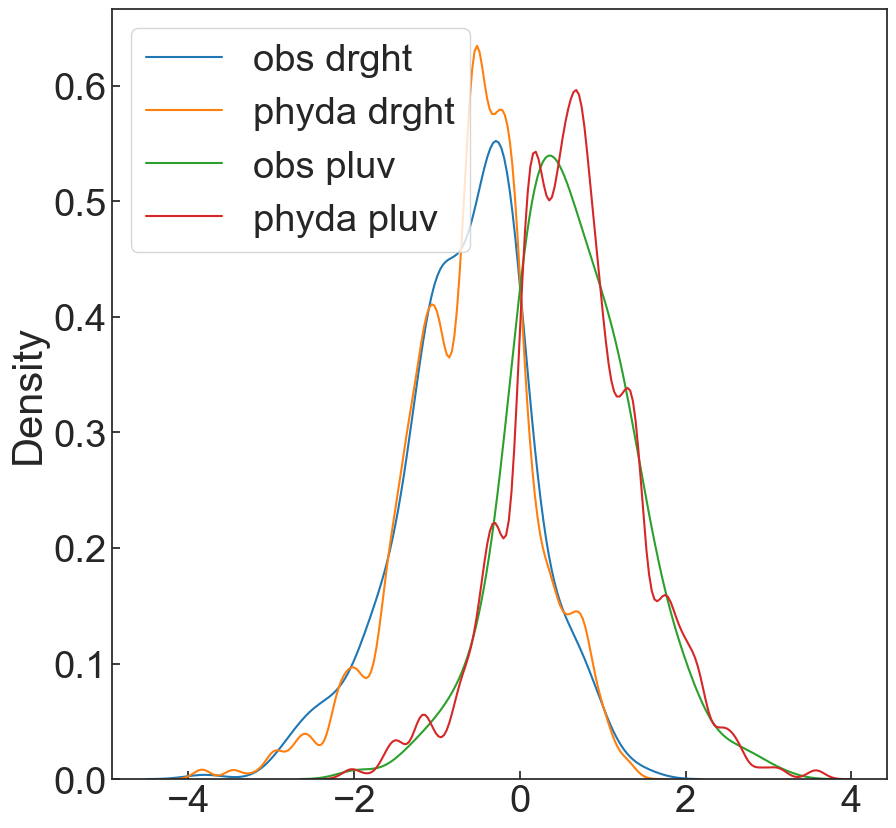

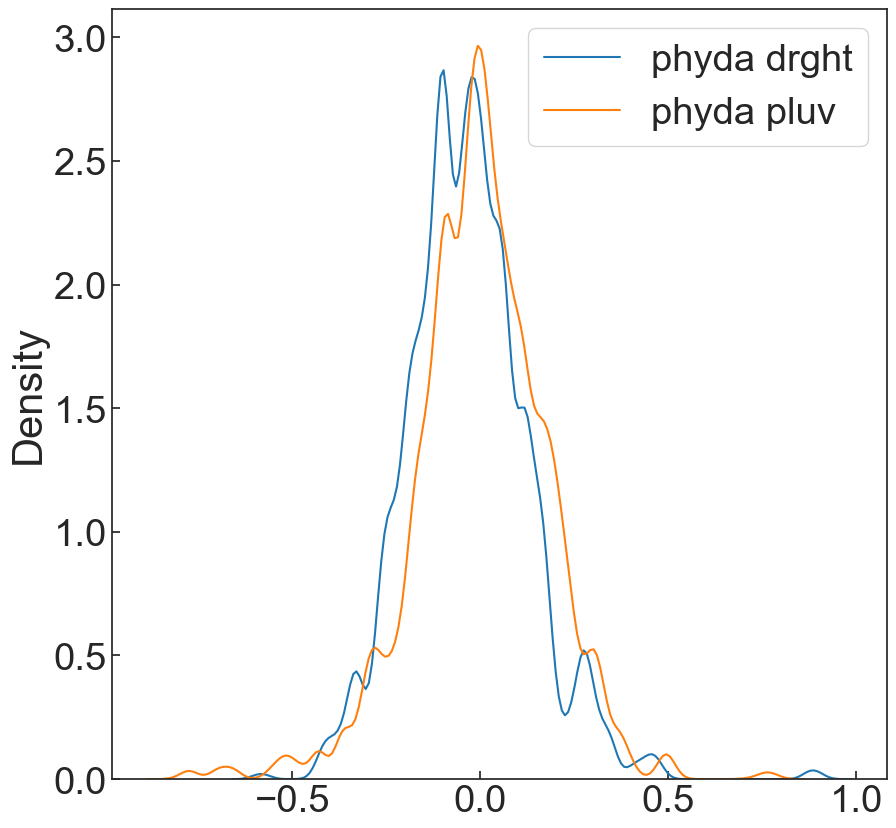

In [21]:
plt.figure(figsize=(10,10))
sns.kdeplot(obs_sm_alldrght,label='obs drght')
sns.kdeplot(allens_smJJA_drght,label='phyda drght')
sns.kdeplot(obs_sm_allpluv,label='obs pluv')
sns.kdeplot(allens_smJJA_pluv,label='phyda pluv')
plt.legend()

plt.figure(figsize=(10,10))
#sns.kdeplot(obs,label='obs drght')
sns.kdeplot(allens_amoJJA_drght,label='phyda drght')
#sns.kdeplot(obs_sm_allpluv,label='obs pluv')
sns.kdeplot(allens_amoJJA_pluv,label='phyda pluv')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


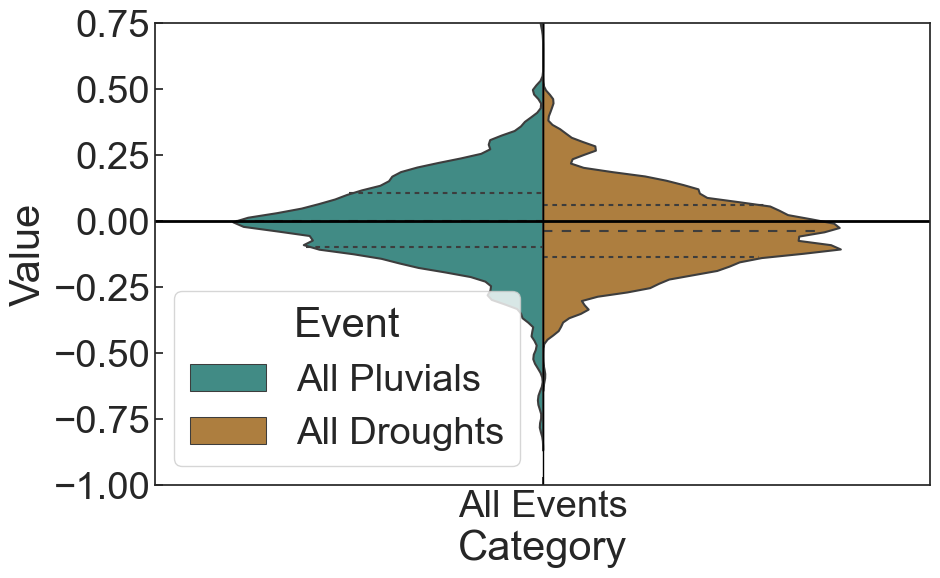

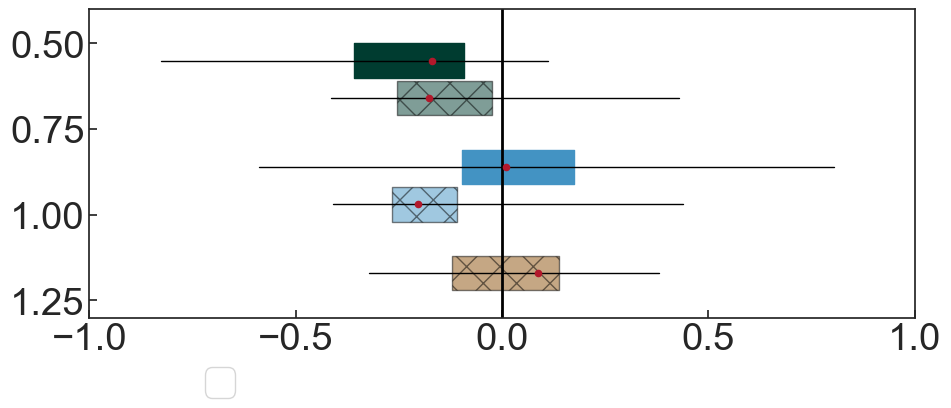

In [59]:
# Variables to Plot: Soil Moisture
var_name        = 'smJJA'; x_ticks=np.arange(-4,4+1,1); x_ticks_box=np.arange(-3,4+1,1)
allens_var      = allens_sm_all.copy(); 
earlypluv_phyda = allens_earlypluv_smJJA.copy()
latepluv_phyda  = allens_latepluv_smJJA.copy()
earlypluv_obs   = obs_sm_earlypluv 
latepluv_obs    = obs_sm_latepluv  
mega21st_obs    = obs_sm_mega21st  

# Variable to Plot: DJF PDO
var_name        = 'pdoDJF'; x_ticks=np.arange(-3,4+1,1); x_ticks_box=np.arange(-3,3+1,1)
allens_var      = allens_pdoDJF_all.copy(); 
earlypluv_phyda = allens_earlypluv_pdoDJF.copy()
latepluv_phyda  = allens_latepluv_pdoDJF.copy()
earlypluv_obs   = obs_pdoDJF_earlypluv 
latepluv_obs    = obs_pdoDJF_latepluv  
mega21st_obs    = obs_pdoDJF_mega21st  

# Variable to Plot: DJF NINO 3.4
var_name        = 'ninoDJF'; x_ticks=np.arange(-2,2+1,1); x_ticks_box=np.arange(-2,3+1,1)
allens_var      = allens_ninoDJF_all.copy(); 
earlypluv_phyda = allens_earlypluv_ninoDJF.copy()
latepluv_phyda  = allens_latepluv_ninoDJF.copy()
earlypluv_obs   = obs_ninoDJF_earlypluv 
latepluv_obs    = obs_ninoDJF_latepluv  
mega21st_obs    = obs_ninoDJF_mega21st  

# Variable to Plot: AMO JJA
var_name        = 'amoJJA'; x_ticks=np.arange(-1.0,0.75+0.25,0.25); x_ticks_box=np.arange(-1.0,1.0+0.5,0.5)
allens_var      = allens_amoJJA_all.copy(); 
earlypluv_phyda = allens_earlypluv_amoJJA.copy()
latepluv_phyda  = allens_latepluv_amoJJA.copy()
earlypluv_obs   = obs_amoJJA_earlypluv 
latepluv_obs    = obs_amoJJA_latepluv  
mega21st_obs    = obs_amoJJA_mega21st  

# Initialize dataframe for PHYDA plotting
df_comp_var = pd.DataFrame(columns=('Event','Value','Category'),index=None)

# Populate Dataframe
df_comp_var['Event']    = lab_all
df_comp_var['Value']    = allens_var
df_comp_var['Category'] = 'All Events'

# Locations of Pluvial and Drought Events
i_allpluv = np.where(df_comp_var.Event=='All Pluvials')[0]
i_alldght = np.where(df_comp_var.Event=='All Droughts')[0]

# Figure
#plt.figure(figsize=(8,7))
plt.figure(figsize=(10,6))
sns.violinplot(data=df_comp_var, y="Value", hue="Event", x="Category", gap=0.0, split=True, palette=new_pal,inner="quart")
plt.plot((0,0),(-4,4),'-', color='k', linewidth=1)
plt.plot((-1,1),(0,0),'-', color='k', linewidth=2)
#plt.ylim(-4,4)
plt.xlim(-0.5,0.5)
plt.yticks(x_ticks)
plt.ylim(np.min(x_ticks),np.max(x_ticks))
plt.savefig('../figures/phyda_pluv_vs_drght_'+var_name+'.pdf',format='pdf')

# MODERN EVENT FIGURE-------------------------------------------------------------------------------------------------------
plt.figure(figsize=(10,5))
# PHYDA EARLY 20TH PLUVIAL
box_top = 0.5; box_bot = 0.6;
box_min = np.percentile(earlypluv_phyda,25); box_max = np.percentile(earlypluv_phyda,75)
line_min = np.min(earlypluv_phyda); line_max = np.max(earlypluv_phyda); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#003c30',alpha=1,zorder=0)
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.scatter(np.median(earlypluv_phyda),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# OBS EARLY 20TH PLUVIAL
box_top = box_top+0.11; box_bot = box_bot+0.11;
box_min = np.percentile(earlypluv_obs,25); box_max = np.percentile(earlypluv_obs,75)
line_min = np.min(earlypluv_obs); line_max = np.max(earlypluv_obs); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#003c30',alpha=0.5,zorder=0,hatch='x',edgecolor='k')
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.scatter(np.median(earlypluv_obs),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# PHYDA LATE 20TH PLUVIAL
box_top = box_top+0.2; box_bot = box_bot+0.2;
box_min = np.percentile(latepluv_phyda,25); box_max = np.percentile(latepluv_phyda,75)
line_min = np.min(latepluv_phyda); line_max = np.max(latepluv_phyda); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#4393c3',alpha=1,zorder=0)
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.scatter(np.median(latepluv_phyda),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# OBS LATE 20TH PLUVIAL
box_top = box_top+0.11; box_bot = box_bot+0.11;
box_min = np.percentile(latepluv_obs,25); box_max = np.percentile(latepluv_obs,75)
line_min = np.min(latepluv_obs); line_max = np.max(latepluv_obs); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#4393c3',alpha=0.5,zorder=0,hatch='x',edgecolor='k')
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.scatter(np.median(latepluv_obs),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# OBS 21ST CENT MEGADROUGHT
box_top = box_top+0.2; box_bot = box_bot+0.2;
box_min = np.percentile(mega21st_obs,25); box_max = np.percentile(mega21st_obs,75)
line_min = np.min(mega21st_obs); line_max = np.max(mega21st_obs); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#8c510a',alpha=0.5,zorder=0,hatch='x',edgecolor='k')
plt.scatter(np.median(mega21st_obs),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# Other Figure Formatting
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.ylim(1.3,0.4)
plt.plot((0,0),(1.3,-0.5),'-', color='k', linewidth=2)
#plt.xlim(-4,4)
#plt.xticks(np.arange(-4,5))
plt.xticks(x_ticks_box)
plt.xlim(np.min(x_ticks_box),np.max(x_ticks_box))
#plt.xlim(-2.5,3)
plt.legend(loc='best', bbox_to_anchor=(0.1, 0., 0.1, -0.1))
plt.tight_layout()
plt.savefig('../figures/phyda_vs_smrec_events_'+var_name+'.pdf',format='pdf')


## Find overlapping Extended drought/pluvial years between PHYDA and PARK Recon

PHYDA Correlation


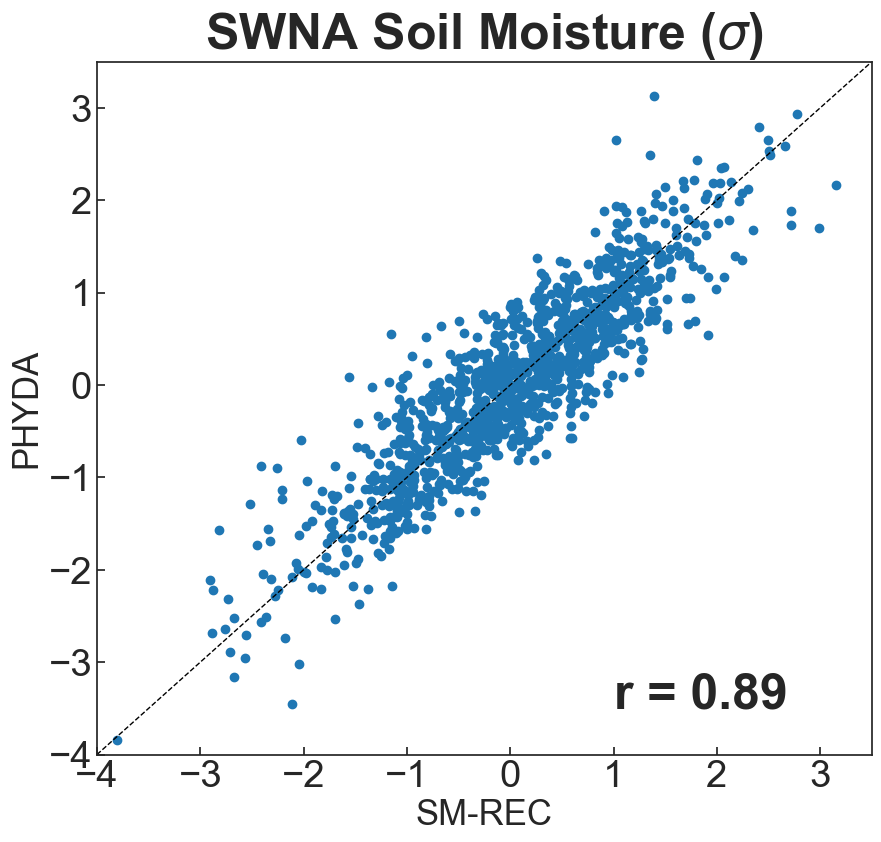

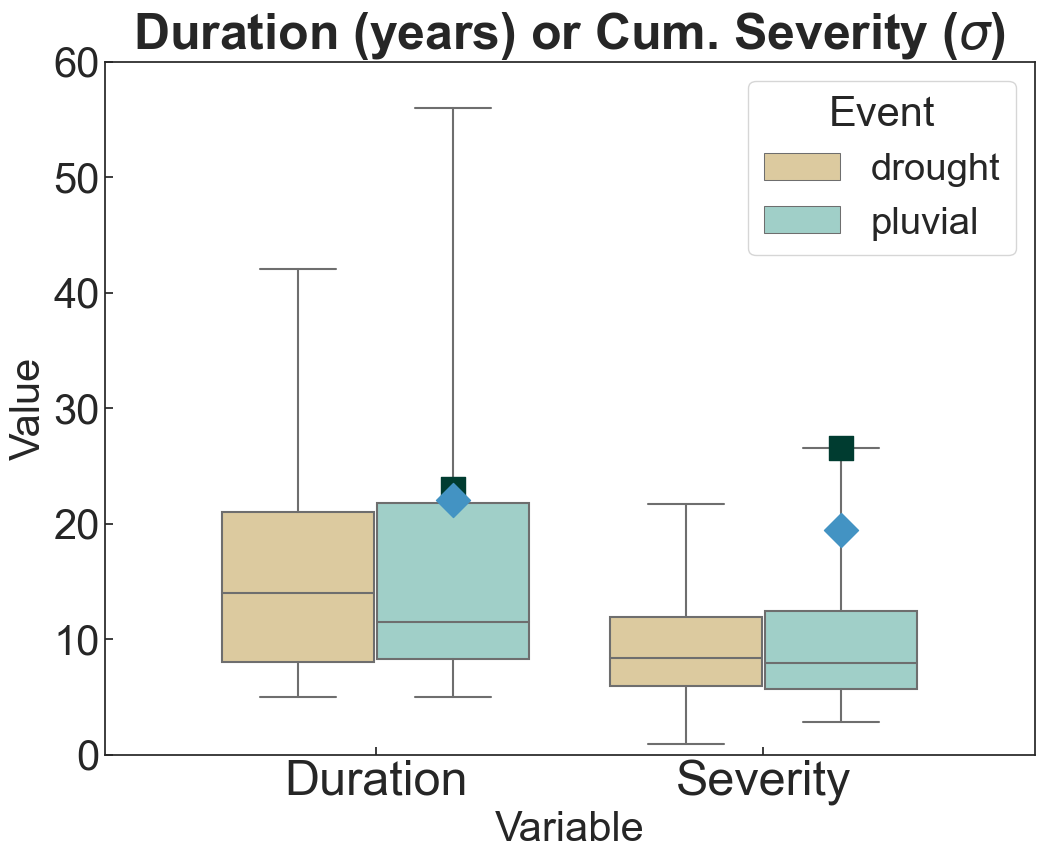

In [320]:
# Trim Recon To Same Period as PHYDA (800-2000)
park_rec_trim = sm_obs_all[np.where(sm_obs_yr<=2000)].copy()

print('PHYDA Correlation')
rval,pval=scipy.stats.pearsonr(park_rec_trim,sm_phyda_all)
rval_txt = np.round((rval*100))/100

plt.figure(figsize=(10,9))
sns.set_style("ticks",style_new)
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1.5})
plt.scatter(park_rec_trim,sm_phyda_all)
plt.title('SWNA Soil Moisture ($\sigma$)',fontweight='bold',fontsize=36)
plt.xlim(-4,3.5)
plt.ylim(-4,3.5)
plt.xticks(np.arange(-4,4))
plt.yticks(np.arange(-4,4))
plt.plot(np.array([-4,3.5]),np.array([-4,3.5]),'--', color='k', linewidth=1)
plt.text(1,-3.5,'r = '+str(rval_txt),fontweight='bold',fontsize=36)
plt.xlabel('SM-REC',fontsize='small')
plt.ylabel('PHYDA',fontsize='small')
plt.savefig('../figures/phyda_vs_park_scatter.eps',format='eps')

# Pull out duration/odd years/cumsum from PHYDA
dur_pluv    = np.array(df_pluvial_phyda['Duration']); dur_drgt    = np.array(df_drought_phyda['Duration'])
cumsum_pluv = np.array(df_pluvial_phyda['CumSum']);   cumsum_drgt = np.array(df_drought_phyda['CumSum'])

# Specific values for 20th century events
i_loc = np.where(df_pluvial_phyda.FirstYr==1978)[0]; pluv_late20th  = df_pluvial_phyda.iloc[i_loc,:]
i_loc = np.where(df_pluvial_phyda.FirstYr==1901)[0]; pluv_early20th = df_pluvial_phyda.iloc[i_loc,:]

# Initialize dataframe
df_comp_var = pd.DataFrame(columns=('Event','Variable','Value'),index=None)

# Concatenate drought/pluvial statistics into single dataframe

# drought loop
for n_ev in np.arange(0,dur_drgt.size):
    
    # Duration
    df_join = pd.DataFrame([['drought','Duration',dur_drgt[n_ev]]],columns=['Event','Variable','Value'])
    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)

    # Cumsum
    df_join = pd.DataFrame([['drought','Severity',np.abs(cumsum_drgt[n_ev])]],columns=['Event','Variable','Value'])
    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)

#    # Outyears
#    df_join = pd.DataFrame([['drought','outyrs',outyrs_drgt[n_ev]]],columns=['Event','Variable','Value'])
#    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)
    
# pluvial loop
for n_ev in np.arange(0,dur_pluv.size):
    
    # Duration
    df_join = pd.DataFrame([['pluvial','Duration',dur_pluv[n_ev]]],columns=['Event','Variable','Value'])
    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)

    # Cumsum
    df_join = pd.DataFrame([['pluvial','Severity',cumsum_pluv[n_ev]]],columns=['Event','Variable','Value'])
    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)
    
#    # Outyears
#    df_join = pd.DataFrame([['pluvial','outyrs',outyrs_pluv[n_ev]]],columns=['Event','Variable','Value'])
#    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)
    
df_comp_var

plt.figure(figsize=(12,9),facecolor="white")
sns.set_style("ticks",style_new)
ax = sns.boxplot(x="Variable", y="Value", hue="Event", data=df_comp_var, whis=100, palette="BrBG")
plt.title('Duration (years) or Cum. Severity ($\sigma$)',fontweight='bold',fontsize=36)
plt.yticks(np.arange(0,70,10),fontsize=30)
plt.xticks(np.arange(0,2,1),fontsize=35)
# Early 20th Century Pluvial
plt.scatter(0.2,pluv_early20th.Duration,s=300,zorder=10,color='#003c30',marker='s')
plt.scatter(1.2,pluv_early20th.CumSum,s=300,zorder=10,color='#003c30',marker='s')
# Late 20th Century Pluvial
plt.scatter(0.2,pluv_late20th.Duration,s=300,zorder=10,color='#4393c3',marker='D')
plt.scatter(1.2,pluv_late20th.CumSum,s=300,zorder=10,color='#4393c3',marker='D')
plt.ylim(0,60)
#plt.savefig('../figures/PHYDA_boxplot_20th_21stcent_events_2023.pdf',format='pdf')


## Violin Plot: Soil Moisture

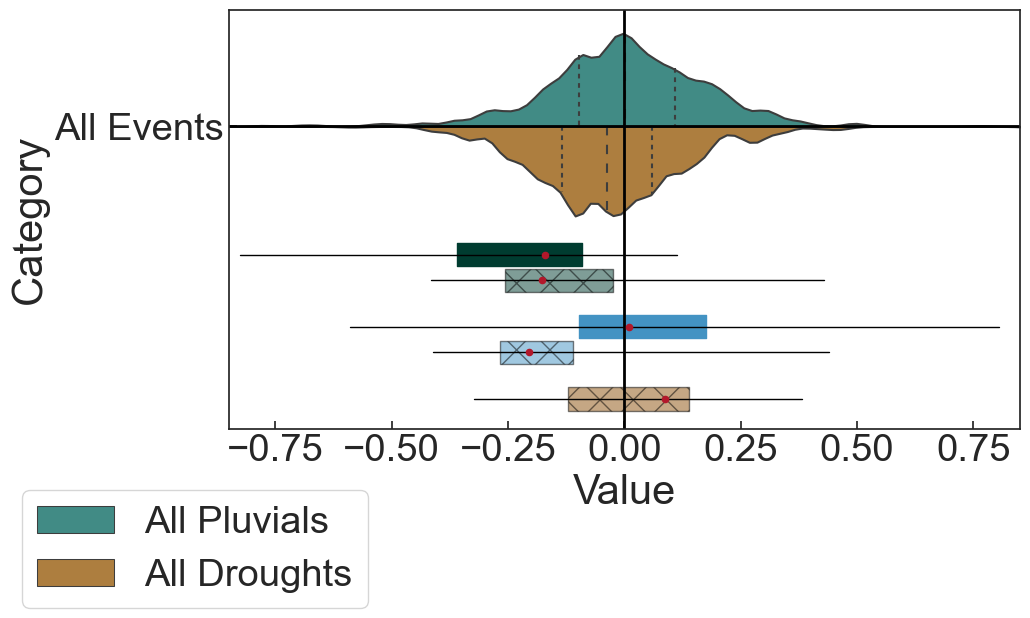

In [254]:
# Variables to Plot: Soil Moisture
var_name        = 'smJJA'; x_ticks=np.arange(-4,4+1,1)
allens_var      = allens_sm_all.copy(); 
earlypluv_phyda = allens_earlypluv_smJJA.copy()
latepluv_phyda  = allens_latepluv_smJJA.copy()
earlypluv_obs   = obs_sm_earlypluv 
latepluv_obs    = obs_sm_latepluv  
mega21st_obs    = obs_sm_mega21st  

## Variable to Plot: DJF PDO
#var_name        = 'pdoDJF'; x_ticks=np.arange(-3,3+1,1)
#allens_var      = allens_pdoDJF_all.copy(); 
#earlypluv_phyda = allens_earlypluv_pdoDJF.copy()
#latepluv_phyda  = allens_latepluv_pdoDJF.copy()
#earlypluv_obs   = obs_pdoDJF_earlypluv 
#latepluv_obs    = obs_pdoDJF_latepluv  
#mega21st_obs    = obs_pdoDJF_mega21st  
#
## Variable to Plot: DJF NINO 3.4
#var_name        = 'ninoDJF'; x_ticks=np.arange(-2,3+1,1)
#allens_var      = allens_ninoDJF_all.copy(); 
#earlypluv_phyda = allens_earlypluv_ninoDJF.copy()
#latepluv_phyda  = allens_latepluv_ninoDJF.copy()
#earlypluv_obs   = obs_ninoDJF_earlypluv 
#latepluv_obs    = obs_ninoDJF_latepluv  
#mega21st_obs    = obs_ninoDJF_mega21st  
#
## Variable to Plot: AMO JJA
#var_name        = 'amoJJA'; x_ticks=np.arange(-1.0,1.0+0.25,0.25)
#allens_var      = allens_amoJJA_all.copy(); 
#earlypluv_phyda = allens_earlypluv_amoJJA.copy()
#latepluv_phyda  = allens_latepluv_amoJJA.copy()
#earlypluv_obs   = obs_amoJJA_earlypluv 
#latepluv_obs    = obs_amoJJA_latepluv  
#mega21st_obs    = obs_amoJJA_mega21st  

# Initialize dataframe for PHYDA plotting
df_comp_var = pd.DataFrame(columns=('Event','Value','Category'),index=None)

# Populate Dataframe
df_comp_var['Event']    = lab_all
df_comp_var['Value']    = allens_var
df_comp_var['Category'] = 'All Events'

# Figure
plt.figure(figsize=(11,7))
sns.violinplot(data=df_comp_var, x="Value", hue="Event", y="Category", gap=0.0, split=True, palette=new_pal,inner="quart")
plt.plot((-4,4),(0,0),'-', color='k', linewidth=2)
# PHYDA EARLY 20TH PLUVIAL
box_top = 0.5; box_bot = 0.6;
box_min = np.percentile(earlypluv_phyda,25); box_max = np.percentile(earlypluv_phyda,75)
line_min = np.min(earlypluv_phyda); line_max = np.max(earlypluv_phyda); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#003c30',alpha=1,zorder=0)
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.scatter(np.median(earlypluv_phyda),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# OBS EARLY 20TH PLUVIAL
box_top = box_top+0.11; box_bot = box_bot+0.11;
box_min = np.percentile(earlypluv_obs,25); box_max = np.percentile(earlypluv_obs,75)
line_min = np.min(earlypluv_obs); line_max = np.max(earlypluv_obs); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#003c30',alpha=0.5,zorder=0,hatch='x',edgecolor='k')
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.scatter(np.median(earlypluv_obs),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# PHYDA LATE 20TH PLUVIAL
box_top = box_top+0.2; box_bot = box_bot+0.2;
box_min = np.percentile(latepluv_phyda,25); box_max = np.percentile(latepluv_phyda,75)
line_min = np.min(latepluv_phyda); line_max = np.max(latepluv_phyda); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#4393c3',alpha=1,zorder=0)
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.scatter(np.median(latepluv_phyda),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# OBS LATE 20TH PLUVIAL
box_top = box_top+0.11; box_bot = box_bot+0.11;
box_min = np.percentile(latepluv_obs,25); box_max = np.percentile(latepluv_obs,75)
line_min = np.min(latepluv_obs); line_max = np.max(latepluv_obs); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#4393c3',alpha=0.5,zorder=0,hatch='x',edgecolor='k')
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.scatter(np.median(latepluv_obs),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# OBS 21ST CENT MEGADROUGHT
box_top = box_top+0.2; box_bot = box_bot+0.2;
box_min = np.percentile(mega21st_obs,25); box_max = np.percentile(mega21st_obs,75)
line_min = np.min(mega21st_obs); line_max = np.max(mega21st_obs); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#8c510a',alpha=0.5,zorder=0,hatch='x',edgecolor='k')
plt.scatter(np.median(mega21st_obs),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# Other Figure Formatting
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.ylim(1.3,-0.5)
plt.plot((0,0),(1.3,-0.5),'-', color='k', linewidth=2)
#plt.xlim(-4,4)
#plt.xticks(np.arange(-4,5))
plt.xticks(x_ticks)
plt.xlim(np.min(x_ticks),np.max(x_ticks))
#plt.xlim(-0.85,0.85)
plt.legend(loc='best', bbox_to_anchor=(0.1, 0., 0.1, -0.1))
plt.tight_layout()
plt.savefig('../figures/phyda_park_ens_comp_'+var_name+'.pdf',format='pdf')


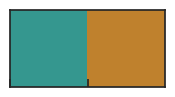

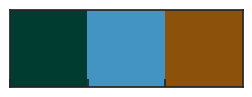

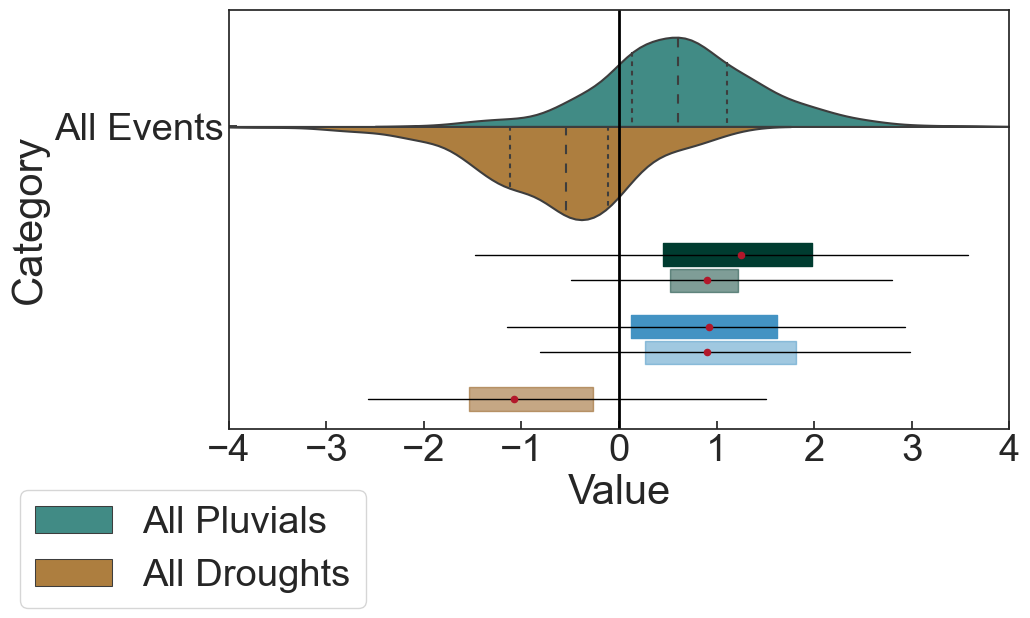

In [257]:
# Initialize dataframe for plotting
df_comp_var = pd.DataFrame(columns=('Event','Value','Category'),index=None)

# Pluvial Loop
for n_ev in np.arange(0,i_pluv_event_phyda.size): 
    df_join1 = pd.DataFrame([['All Pluvials',sm_pluv_event_phyda[n_ev],'All Events']],columns=['Event','Value','Category'])
    df_comp_var = pd.concat([df_comp_var, df_join1], ignore_index=True)
# Drought Loop
for n_ev in np.arange(0,i_drgt_event_phyda.size): 
    df_join1 = pd.DataFrame([['All Droughts',sm_drgt_event_phyda[n_ev],'All Events']],columns=['Event','Value','Category'])
    df_comp_var = pd.concat([df_comp_var, df_join1], ignore_index=True) 
            
old_pal = sns.color_palette(('#003c30','#4393c3','#8c510a'))
new_pal = sns.color_palette(('#35978f','#bf812d'))
sns.palplot(new_pal)
sns.palplot(old_pal)
        
df_comp_var

plt.figure(figsize=(11,7))
sns.violinplot(data=df_comp_var, x="Value", hue="Event", y="Category", gap=0.0, split=True, palette=new_pal,inner="quart")
# PHYDA EARLY 20TH PLUVIAL
box_top = 0.5; box_bot = 0.6;
box_min = np.percentile(sm_earlypluv_phyda,25); box_max = np.percentile(sm_earlypluv_phyda,75)
line_min = np.min(sm_earlypluv_phyda); line_max = np.max(sm_earlypluv_phyda); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#003c30',alpha=1,zorder=0)
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.scatter(np.median(sm_earlypluv_phyda),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# PARK EARLY 20TH PLUVIAL
box_top = box_top+0.11; box_bot = box_bot+0.11;
box_min = np.percentile(sm_earlypluv_park,25); box_max = np.percentile(sm_earlypluv_park,75)
line_min = np.min(sm_earlypluv_park); line_max = np.max(sm_earlypluv_park); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#003c30',alpha=0.5,zorder=0)
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.scatter(np.median(sm_earlypluv_park),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# PHYDA LATE 20TH PLUVIAL
box_top = box_top+0.2; box_bot = box_bot+0.2;
box_min = np.percentile(sm_latepluv_phyda,25); box_max = np.percentile(sm_latepluv_phyda,75)
line_min = np.min(sm_latepluv_phyda); line_max = np.max(sm_latepluv_phyda); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#4393c3',alpha=1,zorder=0)
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.scatter(np.median(sm_latepluv_phyda),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# PARK LATE 20TH PLUVIAL
box_top = box_top+0.11; box_bot = box_bot+0.11;
box_min = np.percentile(sm_latepluv_park,25); box_max = np.percentile(sm_latepluv_park,75)
line_min = np.min(sm_latepluv_park); line_max = np.max(sm_latepluv_park); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#4393c3',alpha=0.5,zorder=0)
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.scatter(np.median(sm_latepluv_park),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# PARK 21ST CENT MEGADROUGHT
box_top = box_top+0.2; box_bot = box_bot+0.2;
box_min = np.percentile(sm_megadrgt_park,25); box_max = np.percentile(sm_megadrgt_park,75)
line_min = np.min(sm_megadrgt_park); line_max = np.max(sm_megadrgt_park); line_cent = (box_top+box_bot)/2
plt.fill_between((box_min, box_max), box_top, box_bot, color='#8c510a',alpha=0.5,zorder=0)
plt.scatter(np.median(sm_megadrgt_park),line_cent,s=20,marker='o',color='#b2182b',zorder=100)
# Other Figure Formatting
plt.plot((line_min,line_max),(line_cent,line_cent),'-', color='k', linewidth=1)
plt.ylim(1.3,-0.5)
plt.plot((0,0),(1.3,-0.5),'-', color='k', linewidth=2)
plt.xlim(-4,4)
plt.xticks(np.arange(-4,5))
plt.legend(loc='best', bbox_to_anchor=(0.1, 0., 0.1, -0.1))
plt.tight_layout()
plt.savefig('../figures/phyda_park_comp_soilmoist.pdf',format='pdf')


In [31]:
print('Pearson''s r (JJA SWNA PDSI vs DJF PDO): ')
print(scipy.stats.pearsonr(pdoDJF_phyda.flatten(),sm_phyda.flatten()))
print('--------------------------------------------------------------------')


Pearsons r (JJA SWNA PDSI vs DJF PDO): 
PearsonRResult(statistic=0.6774046124491361, pvalue=0.0)
--------------------------------------------------------------------


In [25]:
pdoDJF_phyda.shape

(1201, 100)

In [26]:
sm_phyda.shape

(1201, 100)

# extended pluvial years = 497
# extended drought years = 460
# other years = 244
# SUM = 1201
# TOTAL YEARS = 1201

Overlapping Years
[]


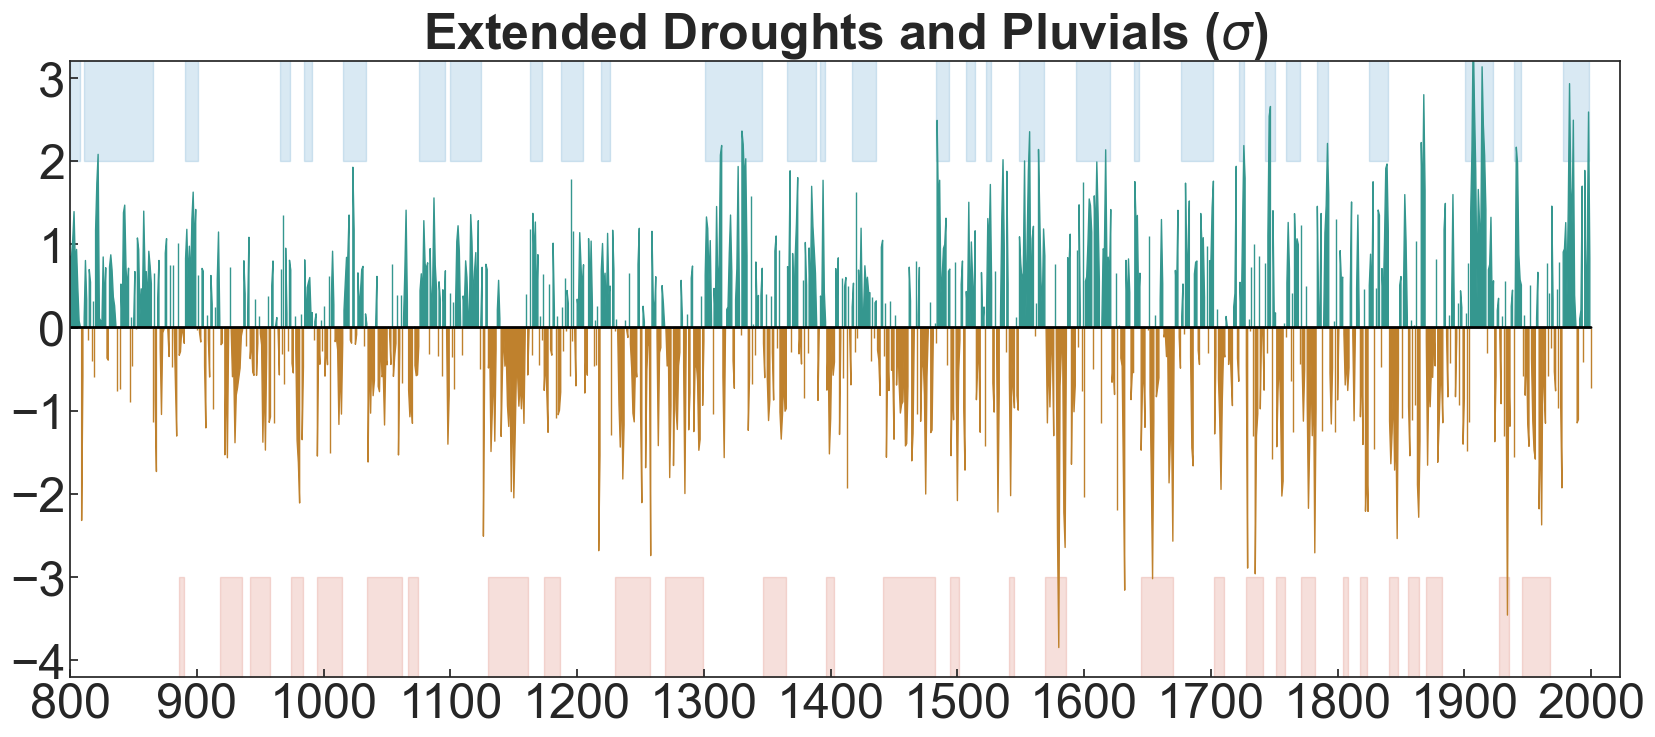

In [322]:
# Load into dataframe
phyda_pd_SMseries = pd.read_csv('../data/phyda_swna_pdsiJJA_detrend.csv',delimiter=',')

# Pull out bias-corrected reconustruction and observational time series
sm_phyda_yr = np.array(phyda_pd_SMseries['Year'][:])
sm_phyda_all = np.array(phyda_pd_SMseries['PDSI'][:])

# For zero line
y_zeros = np.zeros(sm_phyda_yr.shape)

# Create Rolling Means of soil moisture
sm_phyda_5yr  = np.array(pd.Series(sm_phyda_all).rolling(5).mean())
sm_phyda_10yr = np.array(pd.Series(sm_phyda_all).rolling(10).mean())

# Load data
df_pluvial_phyda = pd.read_csv('../data/phyda_pluv_sm10yr_update_2023_detrend.csv')
df_drought_phyda = pd.read_csv('../data/phyda_drght_sm10yr_update_2023_detrend.csv')

# Pull out duration/odd years/cumsum
dur_pluv_phyda    = np.array(df_pluvial_phyda['Duration']); dur_drgt_phyda    = np.array(df_drought_phyda['Duration'])
cumsum_pluv_phyda = np.array(df_pluvial_phyda['CumSum']);   cumsum_drgt_phyda = np.array(df_drought_phyda['CumSum'])
outyrs_pluv_phyda = np.array(df_pluvial_phyda['DryYrs']);   outyrs_drgt_phyda = np.array(df_drought_phyda['WetYrs'])

# Set minimum drought/pluvial length
min_len = 1

# Pull out list of first and last year of pluvial events-------------------------------------------------------
pluv_yrbeg_phyda  = np.array(df_pluvial_phyda.FirstYr[df_pluvial_phyda['Duration']>=min_len])
pluv_yrend_phyda  = np.array(df_pluvial_phyda.LastYr[df_pluvial_phyda['Duration']>=min_len])
pluv_length_phyda = np.array(df_pluvial_phyda.Duration[df_pluvial_phyda['Duration']>=min_len])
pluv_yrterm_phyda = pluv_yrend_phyda+1

# Loop through pluvial events
for n_pluv in np.arange(0,pluv_yrbeg_phyda.size):  
    # All years, current pluvial
    currpluv_yrs_phyda = np.arange(pluv_yrbeg_phyda[n_pluv],pluv_yrend_phyda[n_pluv]+1)

    # If first event, use this to initialize all years array
    if n_pluv==0:
        allpluv_yrs_phyda = currpluv_yrs_phyda.copy()
    # Otherwise, append
    else:
        allpluv_yrs_phyda = np.hstack((allpluv_yrs_phyda,currpluv_yrs_phyda))
    
print('# extended pluvial years =',np.size(allpluv_yrs_phyda))

# Pull out list of first and last year of drought events-------------------------------------------------------
drgt_yrbeg_phyda  = np.array(df_drought_phyda.FirstYr[df_drought_phyda['Duration']>=min_len])
drgt_yrend_phyda  = np.array(df_drought_phyda.LastYr[df_drought_phyda['Duration']>=min_len])
drgt_length_phyda = np.array(df_drought_phyda.Duration[df_drought_phyda['Duration']>=min_len])
drgt_yrterm_phyda = drgt_yrend_phyda+1

# Loop through pluvial events
for n_drgt in np.arange(0,drgt_yrbeg_phyda.size):  
    # All years, current pluvial
    currdrgt_yrs_phyda = np.arange(drgt_yrbeg_phyda[n_drgt],drgt_yrend_phyda[n_drgt]+1)

    # If first event, use this to initialize all years array
    if n_drgt==0:
        alldrgt_yrs_phyda = currdrgt_yrs_phyda.copy()
    # Otherwise, append
    else:
        alldrgt_yrs_phyda = np.hstack((alldrgt_yrs_phyda,currdrgt_yrs_phyda))
    
print('# extended drought years =',np.size(alldrgt_yrs_phyda))

# Years that don't fall within the extended droughts or pluvials
allother_yrs_phyda = np.setxor1d(sm_phyda_yr,np.hstack((alldrgt_yrs_phyda,allpluv_yrs_phyda)))

print('# other years =',np.size(allother_yrs_phyda))

print('# SUM =',np.size(allother_yrs_phyda)+np.size(alldrgt_yrs_phyda)+np.size(allpluv_yrs_phyda))
print('# TOTAL YEARS =',sm_phyda_yr.size)

# Overlapping Years
overlap_yrs = np.intersect1d(alldrgt_yrs_phyda,allpluv_yrs_phyda)
print('')
print('Overlapping Years')
print(overlap_yrs)

# Figure: unsmoothed
plt.figure(figsize=(20,8),facecolor="white")
sns.set_style("ticks",style_new)
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1.5})
plt.plot(sm_phyda_yr,y_zeros,'-', color='k', linewidth=2)
# Shading
i_neg=sm_phyda_all.copy(); i_neg[np.where(i_neg>=0)]=0; i_neg[np.where(i_neg<0)]=1
i_pos=sm_phyda_all.copy(); i_pos[np.where(i_neg==0)]=1; i_pos[np.where(i_neg==1)]=0
plt.fill_between(sm_phyda_yr, y_zeros, sm_phyda_all, where=i_neg, color='#bf812d', alpha=1)
plt.fill_between(sm_phyda_yr, y_zeros, sm_phyda_all, where=i_pos, color='#35978f', alpha=1)
plt.title('Extended Droughts and Pluvials ($\sigma$)',fontweight='bold',fontsize=36)
plt.yticks([-4,-3,-2,-1,0,1,2,3,4],fontsize=35)
# Highlight Extended Droughts
for n_event in enumerate(drgt_length_phyda):
    ymin=-5; ymax=-3
    if n_event[1]>=1:
        plt.fill_between(np.arange(drgt_yrbeg_phyda[n_event[0]]-0.5,drgt_yrend_phyda[n_event[0]]+0.5), ymin, ymax,color='#d6604d',alpha=0.2,zorder=0)
# Highlight Extended Pluvials
for n_event in enumerate(pluv_length_phyda):
    ymin=2; ymax=3.5
    if n_event[1]>=1:
        plt.fill_between(np.arange(pluv_yrbeg_phyda[n_event[0]]-0.5,pluv_yrend_phyda[n_event[0]]+0.5), ymin, ymax,color='#4393c3',alpha=0.2,zorder=0)
plt.xticks([800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000],fontsize=35)
plt.xlim(800,2023)
plt.ylim(-4.2,3.2)
plt.savefig('../figures/phyda_pdsi_1yr_update_pluvs_drghts_detrended.pdf',format='pdf')


## Find overlapping Extended drought/pluvial years between PHYDA and PARK Recon

PHYDA Correlation


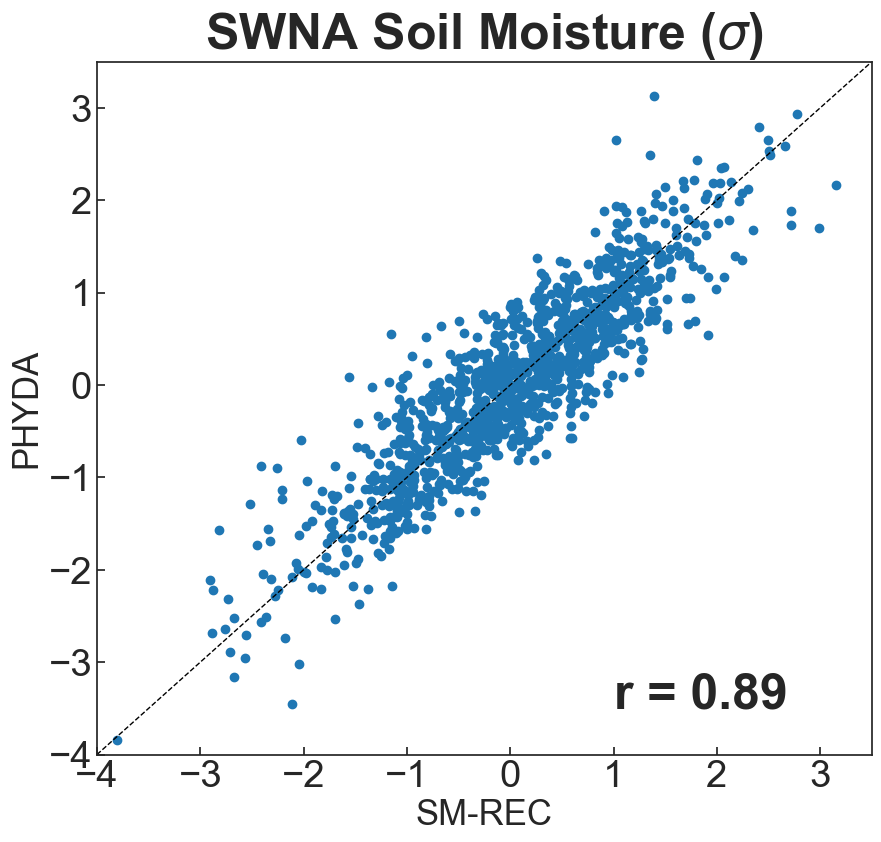

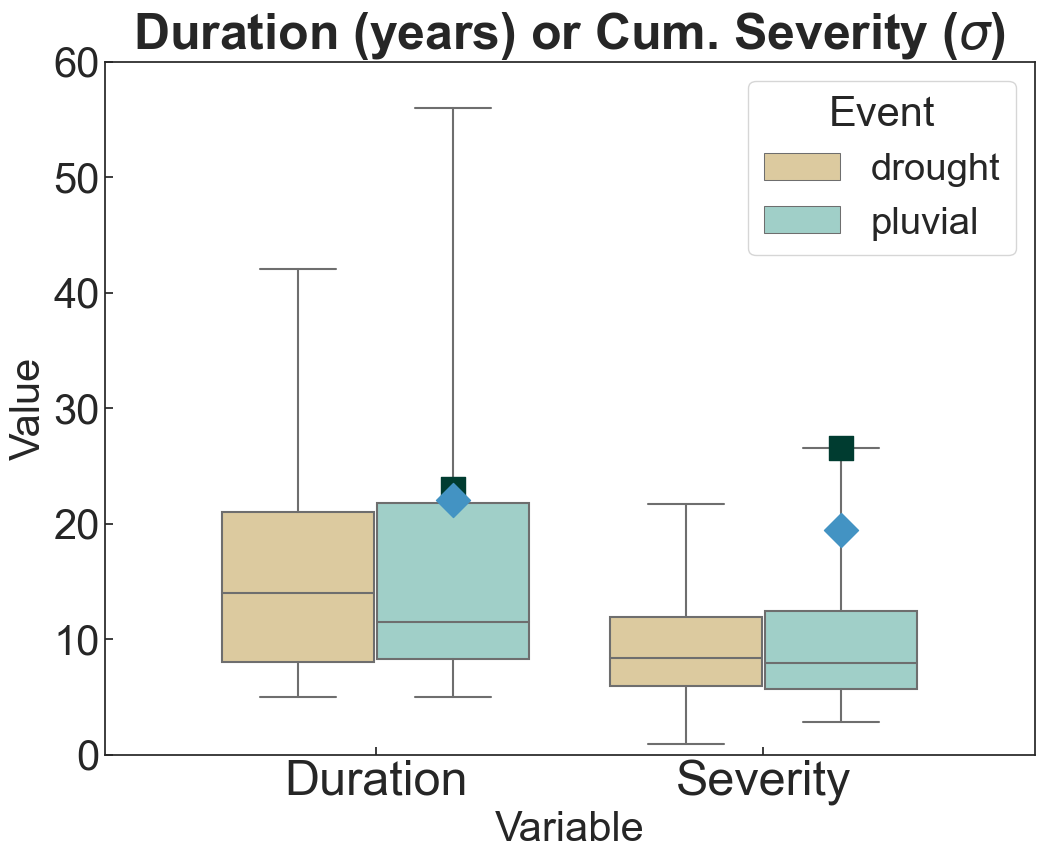

In [320]:
# Trim Recon To Same Period as PHYDA (800-2000)
park_rec_trim = sm_obs_all[np.where(sm_obs_yr<=2000)].copy()

print('PHYDA Correlation')
rval,pval=scipy.stats.pearsonr(park_rec_trim,sm_phyda_all)
rval_txt = np.round((rval*100))/100

plt.figure(figsize=(10,9))
sns.set_style("ticks",style_new)
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1.5})
plt.scatter(park_rec_trim,sm_phyda_all)
plt.title('SWNA Soil Moisture ($\sigma$)',fontweight='bold',fontsize=36)
plt.xlim(-4,3.5)
plt.ylim(-4,3.5)
plt.xticks(np.arange(-4,4))
plt.yticks(np.arange(-4,4))
plt.plot(np.array([-4,3.5]),np.array([-4,3.5]),'--', color='k', linewidth=1)
plt.text(1,-3.5,'r = '+str(rval_txt),fontweight='bold',fontsize=36)
plt.xlabel('SM-REC',fontsize='small')
plt.ylabel('PHYDA',fontsize='small')
plt.savefig('../figures/phyda_vs_park_scatter.eps',format='eps')

# Pull out duration/odd years/cumsum from PHYDA
dur_pluv    = np.array(df_pluvial_phyda['Duration']); dur_drgt    = np.array(df_drought_phyda['Duration'])
cumsum_pluv = np.array(df_pluvial_phyda['CumSum']);   cumsum_drgt = np.array(df_drought_phyda['CumSum'])

# Specific values for 20th century events
i_loc = np.where(df_pluvial_phyda.FirstYr==1978)[0]; pluv_late20th  = df_pluvial_phyda.iloc[i_loc,:]
i_loc = np.where(df_pluvial_phyda.FirstYr==1901)[0]; pluv_early20th = df_pluvial_phyda.iloc[i_loc,:]

# Initialize dataframe
df_comp_var = pd.DataFrame(columns=('Event','Variable','Value'),index=None)

# Concatenate drought/pluvial statistics into single dataframe

# drought loop
for n_ev in np.arange(0,dur_drgt.size):
    
    # Duration
    df_join = pd.DataFrame([['drought','Duration',dur_drgt[n_ev]]],columns=['Event','Variable','Value'])
    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)

    # Cumsum
    df_join = pd.DataFrame([['drought','Severity',np.abs(cumsum_drgt[n_ev])]],columns=['Event','Variable','Value'])
    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)

#    # Outyears
#    df_join = pd.DataFrame([['drought','outyrs',outyrs_drgt[n_ev]]],columns=['Event','Variable','Value'])
#    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)
    
# pluvial loop
for n_ev in np.arange(0,dur_pluv.size):
    
    # Duration
    df_join = pd.DataFrame([['pluvial','Duration',dur_pluv[n_ev]]],columns=['Event','Variable','Value'])
    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)

    # Cumsum
    df_join = pd.DataFrame([['pluvial','Severity',cumsum_pluv[n_ev]]],columns=['Event','Variable','Value'])
    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)
    
#    # Outyears
#    df_join = pd.DataFrame([['pluvial','outyrs',outyrs_pluv[n_ev]]],columns=['Event','Variable','Value'])
#    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)
    
df_comp_var

plt.figure(figsize=(12,9),facecolor="white")
sns.set_style("ticks",style_new)
ax = sns.boxplot(x="Variable", y="Value", hue="Event", data=df_comp_var, whis=100, palette="BrBG")
plt.title('Duration (years) or Cum. Severity ($\sigma$)',fontweight='bold',fontsize=36)
plt.yticks(np.arange(0,70,10),fontsize=30)
plt.xticks(np.arange(0,2,1),fontsize=35)
# Early 20th Century Pluvial
plt.scatter(0.2,pluv_early20th.Duration,s=300,zorder=10,color='#003c30',marker='s')
plt.scatter(1.2,pluv_early20th.CumSum,s=300,zorder=10,color='#003c30',marker='s')
# Late 20th Century Pluvial
plt.scatter(0.2,pluv_late20th.Duration,s=300,zorder=10,color='#4393c3',marker='D')
plt.scatter(1.2,pluv_late20th.CumSum,s=300,zorder=10,color='#4393c3',marker='D')
plt.ylim(0,60)
plt.savefig('../figures/PHYDA_boxplot_20th_21stcent_events_2023.pdf',format='pdf')



In [318]:
df_pluvial_phyda.sort_values('Duration',ascending=False)[0:10]

,FirstYr,LastYr,Duration,DryYrs,MeanAnom,CumSum
1,811.0,866.0,56.0,11.0,0.387372,21.692818
11,1301.0,1346.0,46.0,12.0,0.543857,25.017412
19,1594.0,1621.0,28.0,5.0,0.718389,20.114899
7,1100.0,1125.0,26.0,4.0,0.430202,11.185258
21,1677.0,1702.0,26.0,8.0,0.484520,12.597525
12,1366.0,1389.0,24.0,6.0,0.573021,13.752503
27,1901.0,1923.0,23.0,3.0,1.153763,26.536550
29,1978.0,1999.0,22.0,3.0,0.882293,19.410437
6,1076.0,1096.0,21.0,3.0,0.489352,10.276395
18,1549.0,1569.0,21.0,2.0,0.919132,19.301766
